In [22]:
import numpy as np
import pandas as pd
import loadData
import monteCarloClass
import time

In [23]:
import os
import json
import glob
import pandas as pd
from pathlib import Path

def load_all_model_results():
    """Load all model fit results from the model_fits directory"""
    results = []
    
    # Find all JSON files in model_fits directory
    json_files = glob.glob("model_fits/**/*.json", recursive=True)



    
    
    for file_path in json_files:
  
        try:
            with open(file_path, 'r') as f:
                result = json.load(f)
            
            # Extract participant ID and model type from filename if not in data
            filename = os.path.basename(file_path)
            parts = filename.replace('.json', '').split('_')
            #print(parts)
            if 'participantID' not in result:
                result['participantID'] = parts[0]

            
            result['modelType'] = parts[1]+"_"+parts[3]
            
            if parts[2]!="LapseFree":
                #print("Lapse fixed model, skipping")
                continue

            # Skip results with specific model types
            excluded_models = ["gaussian_sharedPrior", "fusionOnly_sharedPrior", "probabilityMatching_sharedPrior", "switching_sharedPrior"]
            if any(model in result['modelType'] for model in excluded_models):
                # Skip this result
                os.remove(file_path)
                continue
            

            results.append(result)
            
        except Exception as e:
            print(f"Error loading {file_path}: {e}")
    
    return results

# Load all results
all_results = load_all_model_results()
print(f"Loaded {len(all_results)} model fit results")

# Convert to DataFrame for easier analysis
df_results = pd.DataFrame(all_results)
print(f"Participants: {sorted(df_results['participantID'].unique())}")
print(f"Models: {sorted(df_results['modelType'].unique())}\n number of models in comparison is: {len(df_results['modelType'].unique())} ")


Loaded 78 model fit results
Participants: ['all', 'as', 'dt', 'hh', 'ip', 'ln1', 'ln2', 'mh', 'ml', 'mt', 'oy', 'qs', 'sx']
Models: ['fusionOnlyLogNorm_sharedPrior', 'logLinearMismatch_sharedPrior', 'lognorm_sharedPrior', 'probabilityMatchingLogNorm_sharedPrior', 'selection_sharedPrior', 'switchingFree_sharedPrior']
 number of models in comparison is: 6 


In [24]:
df_results

,participantID,modelType,fittedParams,AIC,BIC,logLikelihood,n_conditions
0,sx,switchingFree_sharedPrior,"[0.00100676619969306, 0.05494942788865409, 0.3...",2145.147761,2179.597963,-1064.573881,548
1,sx,lognorm_sharedPrior,"[0.0010001342422045756, 0.33921005301171236, 0...",2151.719866,2181.863793,-1068.859933,548
2,sx,logLinearMismatch_sharedPrior,"[0.05612607853226369, 0.2885361430902179, 0.27...",2168.476558,2198.620485,-1077.238279,548
3,sx,fusionOnlyLogNorm_sharedPrior,"[0.0010010687986155842, 0.33265441676415497, 0...",2153.654938,2179.492590,-1070.827469,548
4,sx,selection_sharedPrior,"[0.023234512085853337, 0.17895699405860788, 0....",2151.861971,2182.005898,-1068.930985,548
...,...,...,...,...,...,...,...
73,ip,selection_sharedPrior,"[0.25820865921918307, 0.08748895739100859, 0.4...",2448.254774,2477.658338,-1217.127387,493
74,ip,probabilityMatchingLogNorm_sharedPrior,"[0.2032555799741298, 0.21163538554217654, 0.85...",2405.480474,2434.884038,-1195.740237,493
75,ip,lognorm_sharedPrior,"[0.133238647881051, 0.25088028517441396, 0.814...",2414.735255,2444.138820,-1200.367628,493
76,ip,logLinearMismatch_sharedPrior,"[0.08524701050376557, 0.2592879330382489, 1.01...",2410.244096,2439.647660,-1198.122048,493


In [25]:
data, dataName = loadData.loadData("as_all.csv")
intensityVariable = "deltaDurS"
sensoryVar = "audNoise"
standardVar = "standardDur"
conflictVar = "conflictDur"
#s
visualStandardVar = "unbiasedVisualStandardDur"
visualTestVar = "unbiasedVisualTestDur"
audioStandardVar = "standardDur"
audioTestVar = "testDurS"
# Instantiate the Monte Carlo class
mc_fitter = monteCarloClass.OmerMonteCarlo(data)
print("Visual test duration range:", data["recordedDurVisualTest"].min(), "to", data["recordedDurVisualTest"].max())
# fit parameters
mc_fitter.nStart = 1 # Number of random starts for optimization
mc_fitter.nSimul = 100 # small number of simulations for quick test
mc_fitter.optimizationMethod= "bads"  # Use BADS for optimization
mc_fitter.modelName = "lognorm"  # Set measurement distribution to Gaussian
mc_fitter.integrationMethod = "analytical"  # Use numerical integration instead of analytical
mc_fitter.freeP_c = False  # Allow different prior widths for conflict conditions
mc_fitter.sharedLambda = False  # Use separate lapse rates for each condition
mc_fitter.dataName = dataName
#print("t_min, t_max:", mc_fitter.t_min, mc_fitter.t_max)


 Total trials before cleaning
: 2156
uniqueSensory: [1.2 0.1] 
 uniqueStandard: [0.5] 
 uniqueConflict: [np.float64(-0.25), np.float64(-0.17), np.float64(-0.08), np.float64(0.0), np.float64(0.08), np.float64(0.17), np.float64(0.25)]
total trials after cleaning: 2155
Visual test duration range: 0.1493 to 1.0912


In [26]:
participantIds=sorted(df_results['participantID'].unique())
modelTypes=sorted(df_results['modelType'].unique())
nParticipants=len(participantIds)
nModels=len(modelTypes)

import fitSaver
import os
participantID="as"
modelType="fusionOnlyLogNorm"

# simulate


In [27]:
df_results

,participantID,modelType,fittedParams,AIC,BIC,logLikelihood,n_conditions
0,sx,switchingFree_sharedPrior,"[0.00100676619969306, 0.05494942788865409, 0.3...",2145.147761,2179.597963,-1064.573881,548
1,sx,lognorm_sharedPrior,"[0.0010001342422045756, 0.33921005301171236, 0...",2151.719866,2181.863793,-1068.859933,548
2,sx,logLinearMismatch_sharedPrior,"[0.05612607853226369, 0.2885361430902179, 0.27...",2168.476558,2198.620485,-1077.238279,548
3,sx,fusionOnlyLogNorm_sharedPrior,"[0.0010010687986155842, 0.33265441676415497, 0...",2153.654938,2179.492590,-1070.827469,548
4,sx,selection_sharedPrior,"[0.023234512085853337, 0.17895699405860788, 0....",2151.861971,2182.005898,-1068.930985,548
...,...,...,...,...,...,...,...
73,ip,selection_sharedPrior,"[0.25820865921918307, 0.08748895739100859, 0.4...",2448.254774,2477.658338,-1217.127387,493
74,ip,probabilityMatchingLogNorm_sharedPrior,"[0.2032555799741298, 0.21163538554217654, 0.85...",2405.480474,2434.884038,-1195.740237,493
75,ip,lognorm_sharedPrior,"[0.133238647881051, 0.25088028517441396, 0.814...",2414.735255,2444.138820,-1200.367628,493
76,ip,logLinearMismatch_sharedPrior,"[0.08524701050376557, 0.2592879330382489, 1.01...",2410.244096,2439.647660,-1198.122048,493


In [28]:
participantIds=sorted(df_results['participantID'].unique())
modelTypes=sorted(df_results['modelType'].unique())
nParticipants=len(participantIds)
nModels=len(modelTypes)

import fitSaver
import os

def loadSimulatedData(mc_fitter, dataName,participantID, modelType=None):
    participantID = dataName.split(".csv")[0]
    #modelType = mc_fitter.modelName

    if mc_fitter.sharedLambda:
        modelType += "_LapseFix"
    else:
        modelType += "_LapseFree"

    if mc_fitter.freeP_c:
        modelType += "_contextualPrior"
    else:
        modelType += "_sharedPrior"

    filename = f"{participantID.split('_')[0]}_{modelType}_simulated.csv"
    filename = os.path.join("simulated_data",participantID.split('_')[0], filename)
    try:
        
        simulatedData= pd.read_csv(filename)
        print(f"Loaded saved simulated data from {filename}")
        return simulatedData
    except:
        print(f"No saved simulated data found at {filename}")
        fitSaver.saveSimulatedData(mc_fitter, mc_fitter.dataName)
        mc_fitter.simulatedData= pd.read_csv(filename)
        print(f"Simulated data saved to {filename}")
        return mc_fitter.simulatedData
#proceed to simulate and save to {filename}
# eg., mc_fitter.simulatedData=loadSimulatedData(mc_fitter, mc_fitter.dataName, participantID=dataName.split(".csv")[0], modelType=mc_fitter.modelName)

# for each participant load simulated data and fit to psychometric functions and save the fitted params in psychometric_fits_simulated/participantID/participantID_modelType_psychometricFits.json
# no need to plot for now, just save the fitted params
import monteCarloClass

def fitPsychometricFunctions2SimulatedData(participantIDs, modelTypes):
    for participantID in participantIds:
        for modelType in ["lognorm"]:#modelTypes:
            row = df_results[(df_results['participantID'] == participantID) & (df_results['modelType'] == modelType)]
            sharedPrior = 'sharedPrior' in modelType
            modelType=modelType.split("_")[0]
            print(f"Processing participant {participantID}, model {modelType}, sharedPrior: {sharedPrior}")
            if row.empty:
                print(f"No results found for participant {participantID} and model {modelType}, skipping.")
                continue
            result = row.iloc[0].to_dict()
            
            data,dataName=loadData.loadData(participantID+"_all.csv")
            # Initialize monteCarloClass with the model parameters
            tmp_mc_fitter = monteCarloClass.OmerMonteCarlo(data)
            tmp_mc_fitter.modelName = result['modelType'].split("_")[0]
            tmp_mc_fitter.sharedLambda = 0
            tmp_mc_fitter.freeP_c = 0
            tmp_mc_fitter.dataName = dataName

            print(f"Simulating data for participant {participantID} using\n model {tmp_mc_fitter.modelName} with sharedLambda={tmp_mc_fitter.sharedLambda}, freeP_c={tmp_mc_fitter.freeP_c}")

            tmp_mc_fitter.modelFit= result['fittedParams']
            simulatedData = loadSimulatedData(mc_fitter=tmp_mc_fitter, dataName=tmp_mc_fitter.dataName,participantID=participantID, modelType=tmp_mc_fitter.modelName)
            simulatedData=  tmp_mc_fitter.simulateMonteCarloData(tmp_mc_fitter.modelFit, tmp_mc_fitter.data)

            tmp_mc_fitter.simulatedData = simulatedData
            tmp_mc_fitter.simDataFit=tmp_mc_fitter.fitMultipleStartingPoints(tmp_mc_fitter.simulatedData,1)
            # save to psychometric_fits_simulated/participantID/participantID_modelType_psychometricFits.json without fitSaver function
            save_dir = os.path.join("psychometric_fits_simulated", participantID.split('_')[0])
            os.makedirs(save_dir, exist_ok=True)
            save_path = os.path.join(save_dir, f"{participantID}_{modelType}_psychometricFits.json")
            print(f"Saving psychometric fits for simulated data to {save_path}")
            fit_data = {
                'participantID': participantID,
                'modelType': modelType,
                'fitParams': tmp_mc_fitter.simDataFit.x.tolist(),  # Convert ndarray to list
            }
            # serialize to json
            with open(save_path, 'w') as f:
                json.dump(fit_data, f)
        
        
def fitPsychometric2RealData(participantIDs):
    for participantID in participantIds:
        row = df_results[(df_results['participantID'] == participantID)]
        print(f"Processing participant {participantID}")
        if row.empty:
            print(f"No results found for participant {participantID}, skipping.")
            continue
        result = row.iloc[0].to_dict()
        
        data,dataName=loadData.loadData(participantID+"_all.csv")
        # Initialize monteCarloClass with the model parameters
        tmp_mc_fitter = monteCarloClass.OmerMonteCarlo(data)

        tmp_mc_fitter.freeP_c = 1
        tmp_mc_fitter.dataName = dataName

        
        tmp_mc_fitter.realDataFit=tmp_mc_fitter.fitMultipleStartingPoints(tmp_mc_fitter.data,1)
        # save to psychometric_fits_real/participantID/participantID_modelType_psychometricFits.json without fitSaver function
        save_dir = os.path.join("psychometric_fits_real", participantID.split('_')[0])
        os.makedirs(save_dir, exist_ok=True)
        save_path = os.path.join(save_dir, f"{participantID}_psychometricFits.json")
        print(f"Saving psychometric fits for real data to {save_path}")
        fit_data = {
            'participantID': participantID,
            'fitParams': tmp_mc_fitter.realDataFit.x.tolist(),  # Convert ndarray to list
        }
        # serialize to json
        with open(save_path, 'w') as f:
            json.dump(fit_data, f)

        
#fitPsychometricFunctions2SimulatedData(participantIds, modelTypes)

#fitPsychometric2RealData(participantIds)
   

# Bootstrap parameter fits

In [29]:
def bootstrap_params_quick(mc_fitter, n_boot=20, maxiter=30, nSimul_boot=300):
    """
    Fast bootstrap for parameter uncertainty.
    - Uses fewer simulations
    - Warm-starts at best parameters
    - Caps optimizer at few iterations
    """
    import numpy as np
    from scipy.optimize import minimize
    
    best_params = mc_fitter.modelFit
    boot_samples = []

    for b in range(n_boot):
        print(f"Bootstrap {b+1}/{n_boot}")

        # --- 1. Simulate a dataset using fitted parameters ---
        sim_df = mc_fitter.simulateMonteCarloData(best_params, mc_fitter.data)

        # --- 2. Create a new fitter for the bootstrap dataset ---
        boot_fitter = monteCarloClass.OmerMonteCarlo(sim_df)
        boot_fitter.modelName = mc_fitter.modelName
        boot_fitter.freeP_c = mc_fitter.freeP_c
        boot_fitter.sharedLambda = mc_fitter.sharedLambda
        
        # Reduce Monte Carlo noise for speed
        boot_fitter.nSimul = nSimul_boot

        # --- 3. Warm-start param optimization from best parameters ---
        def obj_fn(p):
            return boot_fitter.nLLMonteCarloCausal(p, boot_fitter.groupedData)

        # IMPORTANT: bounds must match the model
        #bounds = mc_fitter.fit_bounds   # store your bounds into mc_fitter earlier

        res = minimize(
            obj_fn,
            best_params,
            method="Nelder-Mead",  # faster than BADS, good enough
            options={"maxiter": maxiter}
        )

        boot_samples.append(res.x)

    return np.array(boot_samples)

# # Example usage of bootstrap_params_quick
# participantID = "as"
# modelType = "fusionOnlyLogNorm_sharedPrior"
# row = df_results[(df_results['participantID'] == participantID) & (df_results['modelType'] == modelType)]
# if not row.empty:
#     result = row.iloc[0].to_dict()
    
#     data,dataName=loadData.loadData(participantID+"_all.csv")
#     # Initialize monteCarloClass with the model parameters
#     tmp_mc_fitter = monteCarloClass.OmerMonteCarlo(data)
#     tmp_mc_fitter.modelName = result['modelType'].split("_")[0]
#     tmp_mc_fitter.sharedLambda = 0
#     tmp_mc_fitter.freeP_c = 0
#     tmp_mc_fitter.dataName = dataName

#     print(f"Bootstrapping for participant {participantID} using\n model {tmp_mc_fitter.modelName} with sharedLambda={tmp_mc_fitter.sharedLambda}, freeP_c={tmp_mc_fitter.freeP_c}")

#     tmp_mc_fitter.modelFit= result['fittedParams']
#     boot_samples = bootstrap_params_quick(tmp_mc_fitter, n_boot=10, maxiter=20, nSimul_boot=200)
#     print("Bootstrap samples:\n", boot_samples)

#boot = bootstrap_params_quick(mc_fitter)

# mean_params = boot_samples.mean(axis=0)
# std_params = boot_samples.std(axis=0)
# ci_low = np.percentile(boot_samples, 2.5, axis=0)
# ci_high = np.percentile(boot_samples, 97.5, axis=0)

# print("95% CI per parameter:")
# for i, (lo, hi) in enumerate(zip(ci_low, ci_high)):
#     print(f"Param {i}: [{lo:.3f}, {hi:.3f}]")

Loaded real data psychometric fit for all from psychometric_fits_real/all/all_psychometricFits.json
Loaded simulated data psychometric fit for all, model lognorm from psychometric_fits_simulated/all/all_lognorm_psychometricFits.json✅
Loaded bootstrapped params for all from [[0.139390889651719, 0.13564782177768006, 0.2435082285502287, 0.24159701148340476, 0.1363070650145763, -0.1341204423813304, -0.10072692446499569, 0.009219310241492735, 0.03913452616878988, 0.10817786414393377, 0.0998821516926024, 0.12447798125212461, -0.02807780953429801, -0.02715267741132186, 0.018885067231502104, 0.02558360185910927, 0.03483237499432766, 0.049114733774809925, 0.049435835258191674], [0.1399853530890088, 0.12422740664216128, 0.23435616306419876, 0.24788111652070297, 0.14435535406143393, -0.14684114012023966, -0.09208664573515346, -0.017224117192418557, 0.024386998522060416, 0.09343098167120643, 0.11880906278337588, 0.14161727018479794, -0.03721420181419121, -0.023277976562672758, 0.016788470492352103

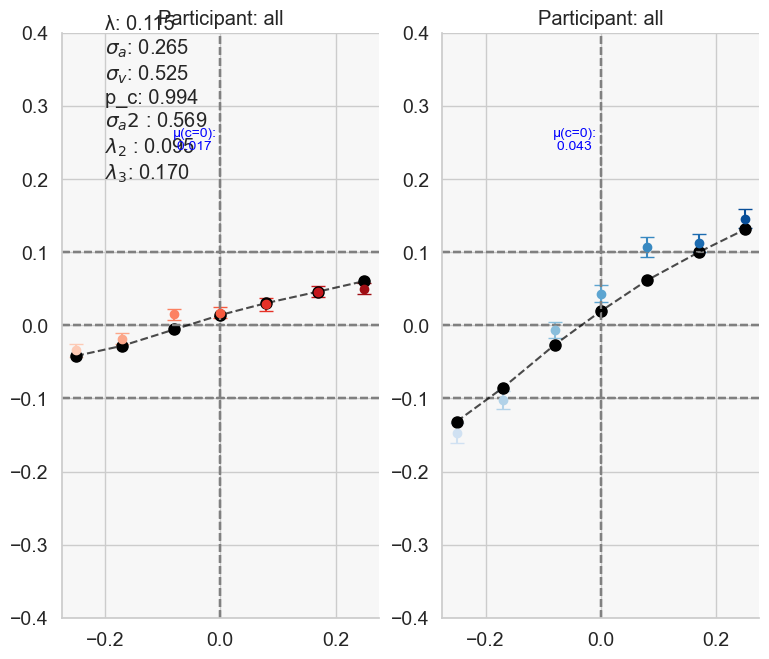

In [30]:
# import bootstrapperSaveLoad functions
import matplotlib.pyplot as plt
from bootstrapperSaveLoad import saveBootstrappedParams, loadBootstrappedParams
import loadResults
import os
import json
import seaborn as sns


def plotAsFuncOfConflictAndSensoryNoise(participantIds, modelTypes, parameterToPLot="mu"):

    lenSubjs=len(participantIds)
    lenModels=len(modelTypes)
    plt.figure(figsize=(9,9*lenSubjs))
    for pNum,participantID in enumerate(participantIds[:1]):
        
        for modelType in ["lognorm"]:#modelTypes:
            modelType=modelType.split("_")[0]
            # 1- read psychometric fits for real data
            real_fit_path = os.path.join("psychometric_fits_real", participantID.split('_')[0], f"{participantID}_psychometricFits.json")
            try:
                with open(real_fit_path, 'r') as f:
                    real_fit = json.load(f)
                print(f"Loaded real data psychometric fit for {participantID} from {real_fit_path}")
            except Exception as e:
                print(f"Error loading real data psychometric fit for {participantID}: {e}")
                continue

            # 2- read psychometric fits for simulated data
            sim_fit_path = os.path.join("psychometric_fits_simulated", participantID.split('_')[0], f"{participantID}_{modelType}_psychometricFits.json")
            try:
                with open(sim_fit_path, 'r') as f:
                    sim_fit = json.load(f)
                print(f"Loaded simulated data psychometric fit for {participantID}, model {modelType} from {sim_fit_path}✅")
    #            print(f"Simulated fit params: {sim_fit['fitParams']}")
            except Exception as e:
                print(f"Error loading simulated data psychometric fit for {participantID}, model {modelType}: {e}\n❗")
                continue
            
            # 3 - Read the bootsterapped fits for real data
            bootPath=participantID+"_dataFit_bootstrapped_params.json"
            dataBootsPath=os.path.join("bootstrapped_params", participantID.split('_')[0], bootPath)
            try:
                with open(dataBootsPath, 'r') as f:
                    content=f.read().strip()
                    dataBoots=json.loads(content) if content else {}
                print(f"Loaded bootstrapped params for {participantID} from {dataBoots}")
            except Exception as e:
                print(f"Error loading bootstrapped params for {participantID} from {dataBoots}: {e}\n❗")
                continue

            # 4 - read monte carlo fit results
            # 4.1 read data
            data, dataName = loadData.loadData(participantID+"_all.csv", verbose=False)
            mc_fitter = monteCarloClass.OmerMonteCarlo(data)
            mc_fitter.modelName = modelType
            mc_fitter.freeP_c = False
            mc_fitter.sharedLambda = False
            mc_fitter.dataName = dataName 
            res=loadResults.loadFitResults(mc_fitter,dataName, modelName=mc_fitter.modelName)
            print(f"Loaded saved fit results: {res}")
            mc_fitter.modelFit= res['fittedParams']
            mc_fitter.logLikelihood= res['logLikelihood']
            mc_fitter.aic= res['AIC']
            mc_fitter.bic= res['BIC']
            mc_fitter.nDataPoints= res['n_conditions']

            # plt.text(-1,0.4,f" Subj: {participantID},  Model: {modelType}")
            # for i in range(len(mc_fitter.modelFit)):
            #     plt.text(-1,0.35-(i*0.05),f" Param {i}: {mc_fitter.modelFit[i]:.4f}")
            # proceed to plot all fits together
            for j, audioNoiseLevel in enumerate(sorted(mc_fitter.uniqueSensory)):
                
                conflict_levels = []
                mu_models=[]
                    # also plot mc_fitter.modelFit as a text on the plot getParamsCausal 
                plt.subplot(lenSubjs,2 ,(pNum*2)+(j+1))
                if j==0:
                    #plt.text(0.05, 0.9-(k*0.05), f"Conflict: {conflictLevel}ms", transform=plt.gca().transAxes, fontsize=10)
                    plt.text(-0.2, 0.2,
                            f"λ: {mc_fitter.modelFit[0]:.3f}\n" +
                            f"$\sigma_a$: {mc_fitter.modelFit[1]:.3f}\n" +
                                f"$\sigma_v$: {mc_fitter.modelFit[2]:.3f}\n" +
                                f"p_c: {mc_fitter.modelFit[3]:.3f}\n" +
                                f"$\sigma_a2$ : {mc_fitter.modelFit[4]:.3f}\n"+
                                f"$\lambda_2$ : {mc_fitter.modelFit[5]:.3f}\n"
                                f"$\lambda_3$: {mc_fitter.modelFit[6]:.3f}",
                    )


                    
                for k, conflictLevel in enumerate(mc_fitter.uniqueConflict):
                        
                

                    conflict_levels.append(conflictLevel)
                    plt.subplot(lenSubjs,2 ,(pNum*2)+(j+1))
                    plt.title(f"Participant: {participantID}")
                    color = sns.color_palette("viridis", as_cmap=True)(k / len(mc_fitter.uniqueConflict))
                    
                    for boot in dataBoots:
                        paramsBootDf = mc_fitter.getParams(boot, conflictLevel, audioNoiseLevel)  # lambda mu sigma
            
                        #plt.scatter(conflictLevel, muBoot, color=color, s=10, alpha=0.1)
                    # plot bootstrap mean
                    if parameterToPLot=="mu":
                        bootMus = [mc_fitter.getParams(boot, conflictLevel, audioNoiseLevel)[1] for boot in dataBoots]
                    
                    
                    elif parameterToPLot=="sigma":
                        bootMus = [mc_fitter.getParams(boot, conflictLevel, audioNoiseLevel)[2] for boot in dataBoots]
                    elif parameterToPLot=="lambda":
                        bootMus = [mc_fitter.getParams(boot, conflictLevel, audioNoiseLevel)[0] for boot in dataBoots]
                    #print(f"length of parameters boots: {len(bootMus)}")
                    #print(f"Conflict Level: {conflictLevel}, mu boots: {bootMus}")

                    # plot as text the mean of mu from data when conflict is 0
                    if conflictLevel == 0:
                        mean_mu_data = np.mean(bootMus)
                        plt.text(0.35, 0.8, f"μ(c=0):\n {mean_mu_data:.3f}", transform=plt.gca().transAxes, fontsize=10, color='blue')
                    
                    # Calculate the sum of mean PSEs (μ) across conflict conditions
                    mean_pse_per_conflict = [np.mean([mc_fitter.getParams(boot, conflict, audioNoiseLevel)[1] for boot in dataBoots]) for conflict in mc_fitter.uniqueConflict]
                    sum_mean_pse = np.sum(mean_pse_per_conflict)
                    #plt.text(0.1, 0.8, f"Sum of PSEs: {sum_mean_pse:.3f}", transform=plt.gca().transAxes, fontsize=10, color='green')

                    if audioNoiseLevel == 0.1:
                        color = sns.color_palette("Reds", as_cmap=True)(0.2 + 0.8 * (k / len(mc_fitter.uniqueConflict)))
                    elif audioNoiseLevel == 1.2:
                        color = sns.color_palette("Blues", as_cmap=True)(0.2+ 0.8 * (k / len(mc_fitter.uniqueConflict)))

                    plt.errorbar(conflictLevel, np.mean(bootMus), yerr=np.std(bootMus), color=color, fmt='o', capsize=5, alpha=1)
                    
                    paramsSimDf = mc_fitter.getParams(sim_fit['fitParams'], conflictLevel, audioNoiseLevel)  # lambda mu sigma

                    if parameterToPLot=="mu":
                        muModel = paramsSimDf[1]
                    elif parameterToPLot=="sigma":
                        muModel = paramsSimDf[2]
                    elif parameterToPLot=="lambda":
                        muModel = paramsSimDf[0]
                    #muModel = paramsSimDf[1]
                    #muData = self.getParams(self.dataFit.x, conflictLevel, audioNoiseLevel)[1]
                    mu_models.append(muModel)


                    plt.plot(conflictLevel, muModel, color="black",  alpha=1,linestyle='--',marker='o',markersize=8)
                    #plt.xlabel(f"Conflict (ms)", fontsize=16)
                    #plt.ylabel("PSE shift (ms)", fontsize=16)
                    plt.axhline(y=0, color='gray', linestyle='--')
                    plt.axvline(x=0, color='gray', linestyle='--')
                    plt.axhline(y=0.1, color='gray', linestyle='--')
                    plt.axhline(y=-0.1, color='gray', linestyle='--')
                    plt.ylim(-0.4, 0.4)
                    #plt.title(f"{self.dataName} AV,A Duration Comp. Noise: {audioNoiseLevel}", fontsize=16)

                    plt.xticks(fontsize=14)
                    plt.yticks(fontsize=14)
                    ax = plt.gca()
                    ax.spines['top'].set_visible(False)
                    ax.spines['right'].set_visible(False)
                    #ax.spines['bottom'].set_visible(False)

                # Convert lists to arrays and sort them for a proper line plot
                conflict_levels = np.array(conflict_levels)
                mu_models = np.array(mu_models)

                sorted_indices = np.argsort(conflict_levels)
                conflict_levels_sorted = conflict_levels[sorted_indices]
                mu_models_sorted = mu_models[sorted_indices]
                plt.plot(conflict_levels_sorted, mu_models_sorted, color="black", alpha=0.7, linestyle='--')
        
            
            

plotAsFuncOfConflictAndSensoryNoise(participantIds, modelTypes, parameterToPLot="mu")


# PLot the posterior per participants

In [31]:
from scipy.stats import norm

# --- FUSION MODEL IMPLEMENTATION ---
def fusion_estimate(m_a, m_v, sigma_a, sigma_v):
    """Bayesian optimal integration of auditory and visual measurements."""
    # Calculate weights based on reliabilities (inverse variances)
    w_a = 1 / sigma_a**2
    w_v = 1 / sigma_v**2
    # Compute the fused estimate
    fused_estimate = (w_a * m_a + w_v * m_v) / (w_a + w_v)
    return fused_estimate

# --- CAUSAL INFERENCE MODEL IMPLEMENTATION ---
def p_single(m,sigma,t_min,t_max):
    """p(m | C=2) and Gaussian measurement noise N(m; y, sigma^2)."""
    hi_cdf= norm.cdf((t_max - m) /sigma)
    lo_cdf=norm.cdf((t_min-m)/sigma)
    return (hi_cdf-lo_cdf)/(t_max-t_min)

# Causal inference model for duration estimation
def L_C1(m_a,m_v,sigma_a,sigma_v,t_min,t_max):
    sigma_c_sq = (sigma_a**2 * sigma_v**2) / (sigma_a**2 + sigma_v**2)
    sigma_c = np.sqrt(sigma_c_sq)
    mu_c = (m_a / sigma_a**2 + m_v / sigma_v**2) / (1 / sigma_a**2 + 1 / sigma_v**2)

    hi_cdf = norm.cdf((t_max-mu_c)/sigma_c)
    lo_cdf = norm.cdf((t_min-mu_c)/sigma_c)
    
    expo = np.exp(-(m_a-m_v)**2/(2*(sigma_a**2+sigma_v**2)))
    
    prior = 1/(t_max-t_min)
    return prior * sigma_c/np.sqrt(sigma_a**2 * sigma_v**2) * (hi_cdf-lo_cdf) * expo

def L_C1_no_prior(m_a, m_v, sigma_a, sigma_v):
    """Likelihood of common source without prior and bounding."""
    sigma_c_sq = (sigma_a**2 * sigma_v**2) / (sigma_a**2 + sigma_v**2)
    sigma_c = np.sqrt(sigma_c_sq)
    mu_c = (m_a / sigma_a**2 + m_v / sigma_v**2) / (1 / sigma_a**2 + 1 / sigma_v**2)
    
    expo = np.exp(-(m_a - m_v)**2 / (2 * (sigma_a**2 + sigma_v**2)))
    
    return sigma_c / np.sqrt(sigma_a**2 * sigma_v**2) * expo



def L_C2(m_a,m_v,sigma_a,sigma_v,t_min,t_max):
    """ Likelihood of separate sources: product of two marginal likelihoods 
        two integral over two hidden duration y_a y_v"""
    return p_single(m_a,sigma_a,t_min,t_max) * p_single(m_v,sigma_v,t_min,t_max)


def L_C2_no_prior(m_a, m_v, sigma_a, sigma_v):
    """Likelihood of separate sources without prior and bounding."""
    return norm.pdf(m_a, loc=m_a, scale=sigma_a) * norm.pdf(m_v, loc=m_v, scale=sigma_v)

def posterior_C1(m_a,m_v,sigma_a,sigma_v,p_c,t_min,t_max):
    """ Posterior probability of common cause P(C=1 | m_a,m_v) """
    # Likelihoods under each causal structure
    L1 = L_C1(m_a,m_v,sigma_a,sigma_v,t_min,t_max)
    L2 = L_C2(m_a,m_v,sigma_a,sigma_v,t_min,t_max)


    post_C1= (L1 * p_c) / (L1 * p_c + L2 * (1 - p_c))
    return post_C1

    # # Unnormalized posteriors
    # post_C1_unnorm = L1 * p_c
    # post_C2_unnorm = L2 * (1 - p_c)
    # # Normalization constant
    # norm_const = post_C1_unnorm + post_C2_unnorm
    

    # # Posterior probabilities
    # post_C1 = post_C1_unnorm / norm_const
    # return post_C1


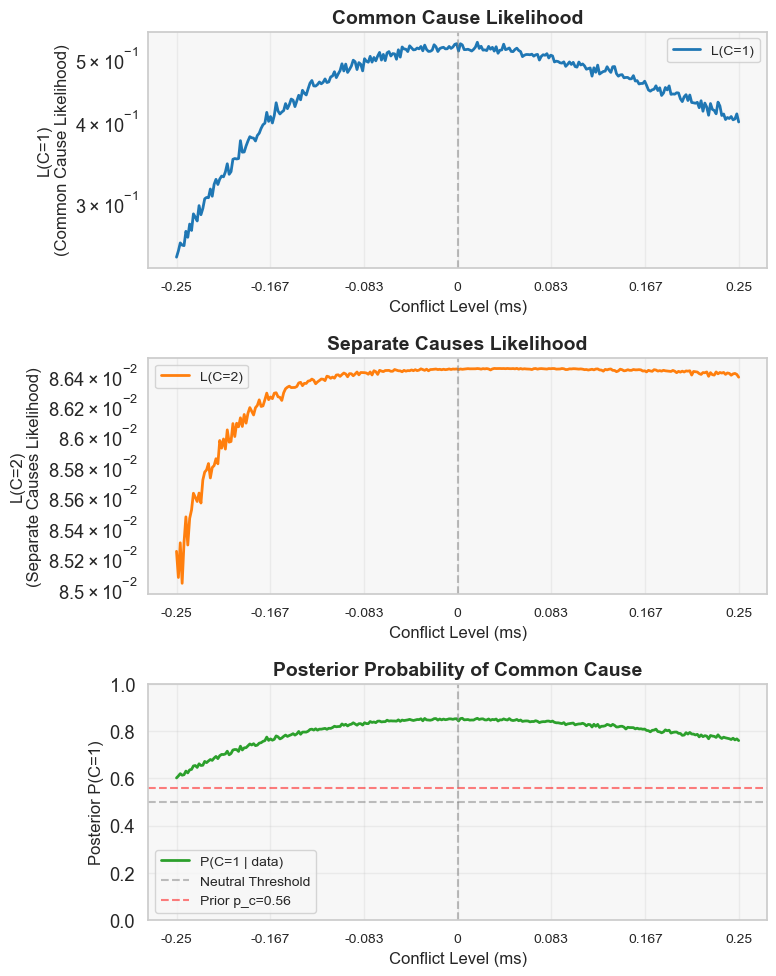

In [32]:
def plot_likelihood_components(sigma_a=0.3, sigma_v=0.3, p_c=0.5, t_min=0.1, t_max=3, measurement="log-space", nSimul=2000):
    """
    Plot L_C1, L_C2, and their ratio across conflict levels to understand asymmetry.
    """
    conflicts = np.linspace(-0.25, +0.25, 300)
    L1_means = []
    L2_means = []
    post_c_means = []
    
    S_a_s = 0.5
    
    for conflict in conflicts:
        S_v_s = S_a_s + conflict
        
        # Skip invalid durations
        if measurement == "log-space" and S_v_s <= 0:
            L1_means.append(np.nan)
            L2_means.append(np.nan)
            post_c_means.append(np.nan)
            continue
        
        # Generate measurements
        if measurement == "log-space":
            m_a_s = np.random.normal(np.log(S_a_s), sigma_a, nSimul)
            m_v_s = np.random.normal(np.log(S_v_s), sigma_v, nSimul)
            t_min_use = np.log(t_min)
            t_max_use = np.log(t_max)
        else:
            m_a_s = np.random.normal(S_a_s, sigma_a, nSimul)
            m_v_s = np.random.normal(S_v_s, sigma_v, nSimul)
            t_min_use = t_min
            t_max_use = t_max
        
        # Calculate likelihoods
        L1 = L_C1(m_a_s, m_v_s, sigma_a, sigma_v, t_min_use, t_max_use)
        L2 = L_C2(m_a_s, m_v_s, sigma_a, sigma_v, t_min_use, t_max_use)
        L1_means.append(np.mean(L1))
        L2_means.append(np.mean(L2))
        
        post_c1 = posterior_C1(m_a_s, m_v_s, sigma_a, sigma_v, p_c, t_min_use, t_max_use)
        post_c_means.append(np.mean(post_c1))
    
    # Create figure with 3 subplots
    fig, axes = plt.subplots(3, 1, figsize=(8, 10), dpi=100)
    plt.subplots_adjust(hspace=0.4)  # Add space between subplots
    
    # Define a consistent color palette
    colors = {
        "L1": "#1f77b4",  # Blue
        "L2": "#ff7f0e",  # Orange
        "Posterior": "#2ca02c"  # Green
    }
    
    # Plot 1: L_C1 (Common cause likelihood)
    axes[0].semilogy(np.array(conflicts) * 1000, L1_means, color=colors["L1"], linewidth=2, label='L(C=1)')
    axes[0].set_xlabel('Conflict Level (ms)', fontsize=12)
    axes[0].set_ylabel('L(C=1)\n(Common Cause Likelihood)', fontsize=12)
    axes[0].set_title('Common Cause Likelihood', fontsize=14, fontweight='bold')
    axes[0].axvline(0, color='gray', linestyle='--', alpha=0.5)
    axes[0].legend(fontsize=10)
    axes[0].grid(alpha=0.3)
    
    # Plot 2: L_C2 (Separate causes likelihood)
    axes[1].semilogy(np.array(conflicts) * 1000, L2_means, color=colors["L2"], linewidth=2, label='L(C=2)')
    axes[1].set_xlabel('Conflict Level (ms)', fontsize=12)
    axes[1].set_ylabel('L(C=2)\n(Separate Causes Likelihood)', fontsize=12)
    axes[1].set_title('Separate Causes Likelihood', fontsize=14, fontweight='bold')
    axes[1].axvline(0, color='gray', linestyle='--', alpha=0.5)
    axes[1].legend(fontsize=10)
    axes[1].grid(alpha=0.3)
    
    # Plot 3: Posterior P(C=1)
    axes[2].plot(np.array(conflicts) * 1000, post_c_means, color=colors["Posterior"], linewidth=2, label='P(C=1 | data)')
    axes[2].set_xlabel('Conflict Level (ms)', fontsize=12)
    axes[2].set_ylabel('Posterior P(C=1)', fontsize=12)
    axes[2].set_title('Posterior Probability of Common Cause', fontsize=14, fontweight='bold')
    axes[2].axhline(0.5, color='gray', linestyle='--', alpha=0.5, label='Neutral Threshold')
    axes[2].axhline(round(p_c, 3), color='red', linestyle='--', alpha=0.5, label=f'Prior p_c={round(p_c, 3)}')
    axes[2].axvline(0, color='gray', linestyle='--', alpha=0.5)
    axes[2].set_ylim([0, 1])
    axes[2].legend(fontsize=10)
    axes[2].grid(alpha=0.3)
    
    # Add consistent x-axis ticks for all subplots
    x_ticks = [-250, -167, -83, 0, 83, 167, 250]
    x_tick_labels = ['-0.25', '-0.167', '-0.083', '0', '0.083', '0.167', '0.25']
    for ax in axes:
        ax.set_xticks(x_ticks)
        ax.set_xticklabels(x_tick_labels, fontsize=10)
    
    plt.tight_layout()
    plt.show()
# Run diagnostic
plot_likelihood_components(sigma_a=0.265, sigma_v=0.3, p_c=0.56, measurement="log-space")

In [33]:
participantIds

['all',
 'as',
 'dt',
 'hh',
 'ip',
 'ln1',
 'ln2',
 'mh',
 'ml',
 'mt',
 'oy',
 'qs',
 'sx']

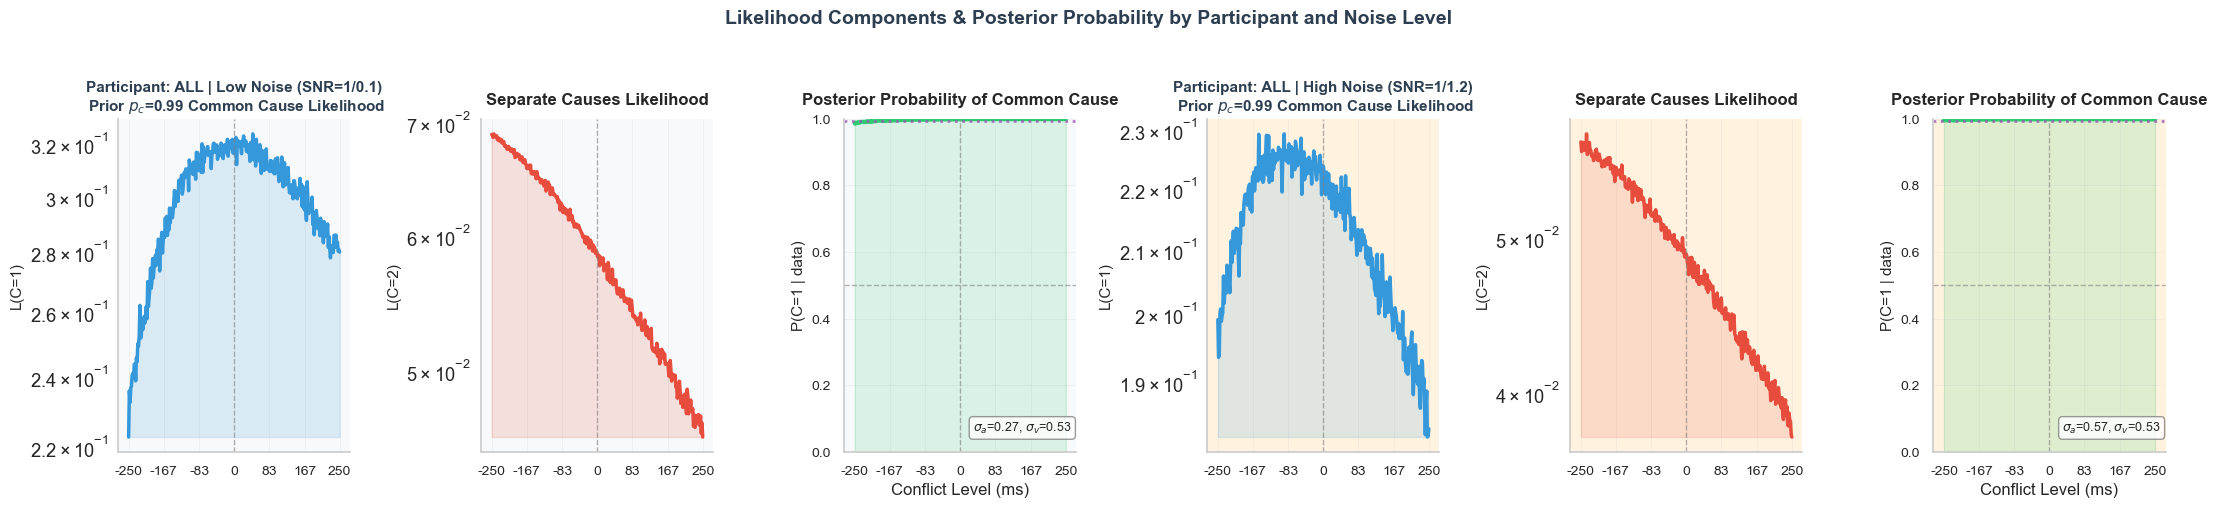

In [34]:
def plot_likelihood_components(sigma_a=0.3, sigma_v=0.3, p_c=0.5, t_min=0.1, t_max=3, 
                              measurement="log-space", nSimul=2000, axes=None, show_plot=True):
    """
    Plot L_C1, L_C2, and their ratio across conflict levels.
    If axes is provided, plot on those axes instead of creating new figure.
    """
    conflicts = np.linspace(-0.25, +0.25, 300)
    L1_means = []
    L2_means = []
    post_c_means = []
    ratio_means = []
    
    S_a_s = 0.5
    
    for conflict in conflicts:
        S_v_s = S_a_s + conflict
        
        if measurement == "log-space" and S_v_s <= 0:
            L1_means.append(np.nan)
            L2_means.append(np.nan)
            ratio_means.append(np.nan)
            post_c_means.append(np.nan)
            continue
        
        # Generate measurements
        if measurement == "log-space":
            m_a_s = np.random.normal(np.log(S_a_s), sigma_a, nSimul)
            m_v_s = np.random.normal(np.log(S_v_s), sigma_v, nSimul)
            t_min_use = np.log(t_min)
            t_max_use = np.log(t_max)
        else:
            m_a_s = np.random.normal(S_a_s, sigma_a, nSimul)
            m_v_s = np.random.normal(S_v_s, sigma_v, nSimul)
            t_min_use = t_min
            t_max_use = t_max
        
        # Calculate likelihoods
        L1 = L_C1(m_a_s, m_v_s, sigma_a, sigma_v, t_min_use, t_max_use)
        L2 = L_C2(m_a_s, m_v_s, sigma_a, sigma_v, t_min_use, t_max_use)
        L1_means.append(np.mean(L1))
        L2_means.append(np.mean(L2))
        
        post_c1 = posterior_C1(m_a_s, m_v_s, sigma_a, sigma_v, p_c, t_min_use, t_max_use)
        post_c_means.append(np.mean(post_c1))
        
        with np.errstate(divide='ignore', invalid='ignore'):
            ratio = L1 / (L1 + L2)
            ratio_means.append(np.mean(ratio))
    
    # Define color palette
    colors = {
        "L1": "#3498db",      # Bright blue
        "L2": "#e74c3c",      # Bright red
        "Posterior": "#2ecc71", # Bright green
        "prior": "#9b59b6"    # Purple for prior line
    }
    
    # Use provided axes or create new figure
    if axes is None and show_plot:
        fig, axes = plt.subplots(3, 1, figsize=(10, 9), dpi=120)
        plt.subplots_adjust(hspace=0.35)
        created_fig = True
    else:
        created_fig = False
    
    if show_plot:
        conflicts_ms = np.array(conflicts) * 1000
        
        # Plot 1: L_C1 (Common cause likelihood)
        axes[0].semilogy(conflicts_ms, L1_means, color=colors["L1"], linewidth=2.5, label='L(C=1)')
        axes[0].fill_between(conflicts_ms, np.nanmin(L1_means), L1_means, alpha=0.15, color=colors["L1"])
        axes[0].set_ylabel('L(C=1)', fontsize=11, fontweight='medium')
        axes[0].set_title('Common Cause Likelihood', fontsize=12, fontweight='bold', pad=10)
        axes[0].axvline(0, color='gray', linestyle='--', alpha=0.6, linewidth=1)
        axes[0].grid(True, alpha=0.3, linestyle='-', linewidth=0.5)
        axes[0].spines['top'].set_visible(False)
        axes[0].spines['right'].set_visible(False)
        
        # Plot 2: L_C2 (Separate causes likelihood)
        axes[1].semilogy(conflicts_ms, L2_means, color=colors["L2"], linewidth=2.5, label='L(C=2)')
        axes[1].fill_between(conflicts_ms, np.nanmin(L2_means), L2_means, alpha=0.15, color=colors["L2"])
        axes[1].set_ylabel('L(C=2)', fontsize=11, fontweight='medium')
        axes[1].set_title('Separate Causes Likelihood', fontsize=12, fontweight='bold', pad=10)
        axes[1].axvline(0, color='gray', linestyle='--', alpha=0.6, linewidth=1)
        axes[1].grid(True, alpha=0.3, linestyle='-', linewidth=0.5)
        axes[1].spines['top'].set_visible(False)
        axes[1].spines['right'].set_visible(False)
        
        # Plot 3: Posterior P(C=1)
        axes[2].plot(conflicts_ms, post_c_means, color=colors["Posterior"], linewidth=3, label='P(C=1 | data)')
        axes[2].fill_between(conflicts_ms, 0, post_c_means, alpha=0.15, color=colors["Posterior"])
        axes[2].axhline(0.5, color='gray', linestyle='--', alpha=0.6, linewidth=1, label='Chance')
        axes[2].axhline(p_c, color=colors["prior"], linestyle=':', alpha=0.8, linewidth=2, label=f'Prior p_c={p_c:.2f}')
        axes[2].axvline(0, color='gray', linestyle='--', alpha=0.6, linewidth=1)
        axes[2].set_xlabel('Conflict Level (ms)', fontsize=12, fontweight='medium')
        axes[2].set_ylabel('P(C=1 | data)', fontsize=11, fontweight='medium')
        axes[2].set_title('Posterior Probability of Common Cause', fontsize=12, fontweight='bold', pad=10)
        axes[2].set_ylim([0, 1])
        axes[2].grid(True, alpha=0.3, linestyle='-', linewidth=0.5)
        axes[2].spines['top'].set_visible(False)
        axes[2].spines['right'].set_visible(False)
        
        # Add parameter info box to posterior plot
        param_text = f'$\sigma_a$={sigma_a:.2f}, $\sigma_v$={sigma_v:.2f}'
        axes[2].text(0.98, 0.05, param_text, transform=axes[2].transAxes, fontsize=9,
                    verticalalignment='bottom', horizontalalignment='right',
                    bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8, edgecolor='gray'))
        
        # Set consistent x-axis ticks for all subplots
        x_ticks = [-250, -167, -83, 0, 83, 167, 250]
        x_tick_labels = ['-250', '-167', '-83', '0', '83', '167', '250']
        for ax in axes:
            ax.set_xticks(x_ticks)
            ax.set_xticklabels(x_tick_labels, fontsize=10)
            ax.tick_params(axis='both', which='major', labelsize=10)
        
        if created_fig:
            plt.tight_layout()
    
    return conflicts, L1_means, L2_means, post_c_means


def plotPosteriorsPerSubj(participantIds, modelTypes, parameterToPLot="mu"):
    lenSubjs = len(participantIds)
    
    # Create figure with better spacing
    fig, axes = plt.subplots(lenSubjs, 6, figsize=(22, 5*lenSubjs), dpi=100)
    plt.subplots_adjust(hspace=0.4, wspace=0.3)
    
    # Ensure axes is 2D even for single subject
    if lenSubjs == 1:
        axes = axes.reshape(1, -1)
    
    # Define noise level colors
    noise_colors = {
        0.1: {'L1': '#2980b9', 'L2': '#c0392b', 'Post': '#27ae60'},  # Low noise - darker
        1.2: {'L1': '#85c1e9', 'L2': '#f1948a', 'Post': '#82e0aa'}   # High noise - lighter
    }
    
    for pNum, participantID in enumerate(participantIds):
        for modelType in ["lognorm"]:
            modelType = modelType.split("_")[0]
            
            # Load data and fit results
            data, dataName = loadData.loadData(participantID+"_all.csv", verbose=False)
            mc_fitter = monteCarloClass.OmerMonteCarlo(data)
            t_min_data = mc_fitter.data_t_min
            t_max_data = mc_fitter.data_t_max
            mc_fitter.modelName = modelType
            mc_fitter.freeP_c = False
            mc_fitter.sharedLambda = False
            mc_fitter.dataName = dataName 
            res = loadResults.loadFitResults(mc_fitter, dataName, modelName=mc_fitter.modelName)
            mc_fitter.modelFit = res['fittedParams']
            
            sigma_v = mc_fitter.modelFit[2]
            p_c = mc_fitter.modelFit[3]
            
            for j, audioNoiseLevel in enumerate(sorted(mc_fitter.uniqueSensory)):
                if audioNoiseLevel == 0.1:
                    sigma_a = mc_fitter.modelFit[1]
                    noise_label = "Low Noise"
                elif audioNoiseLevel == 1.2:
                    sigma_a = mc_fitter.modelFit[4]
                    noise_label = "High Noise"
                
                # Create axes for this noise level (3 subplots)
                start_col = j * 3
                subplot_axes = [axes[pNum, start_col], axes[pNum, start_col+1], axes[pNum, start_col+2]]
                
                # Call plotting function with specific axes
                plot_likelihood_components(
                    sigma_a=sigma_a, 
                    sigma_v=sigma_v, 
                    p_c=p_c, 
                    t_min=t_min_data, 
                    t_max=t_max_data, 
                    measurement="log-space",
                    axes=subplot_axes,
                    show_plot=True
                )
                
                # Add participant and noise info with styled title
                subplot_axes[0].set_title(
                    f"Participant: {participantID.upper()} | {noise_label} (SNR=1/{audioNoiseLevel})\n Prior $p_c$={p_c:.2f} "+
                    subplot_axes[0].get_title(),
                    fontsize=11, fontweight='bold', color='#2c3e50'
                )
                
                # Add subtle background color to distinguish noise conditions
                bg_color = '#f8f9fa' if audioNoiseLevel == 0.1 else '#fff3e0'
                for ax in subplot_axes:
                    ax.set_facecolor(bg_color)

    # Add overall title
    fig.suptitle('Likelihood Components & Posterior Probability by Participant and Noise Level', 
                 fontsize=14, fontweight='bold', y=1.02, color='#2c3e50')
    
    plt.tight_layout()
    plt.show()

# Run the improved plot

plotPosteriorsPerSubj(participantIds[:1], modelTypes, parameterToPLot="mu")

Loaded saved fit results: {'participantID': 'all', 'modelType': 'lognorm_LapseFree_sharedPrior', 'fittedParams': [0.1148295617881552, 0.26510078233769274, 0.5252749505013505, 0.9944184451434158, 0.568894575886471, 0.09512338326531265, 0.17045617522356135], 'AIC': 25336.161906657137, 'BIC': 25382.38164859882, 'logLikelihood': -12661.080953328568, 'n_conditions': 5447}
--------------------------------------------------
Participant: all, sigma_a: 0.26510078233769274, sigma_v: 0.5252749505013505, p_c: 0.9944184451434158, sigma_a2: 0.568894575886471, lambda_2: 0.09512338326531265, lambda_3: 0.17045617522356135
--------------------------------------------------
Loaded saved fit results: {'participantID': 'as', 'modelType': 'lognorm_LapseFree_sharedPrior', 'fittedParams': [0.0518914042053049, 0.22862421389736387, 0.5003566807451038, 0.6465994239029974, 0.5956168872412269, 0.09559286076953433, 0.02038653079797979], 'AIC': 2258.499805436624, 'BIC': 2286.831410689948, 'logLikelihood': -1122.2499

<Figure size 800x2400 with 0 Axes>

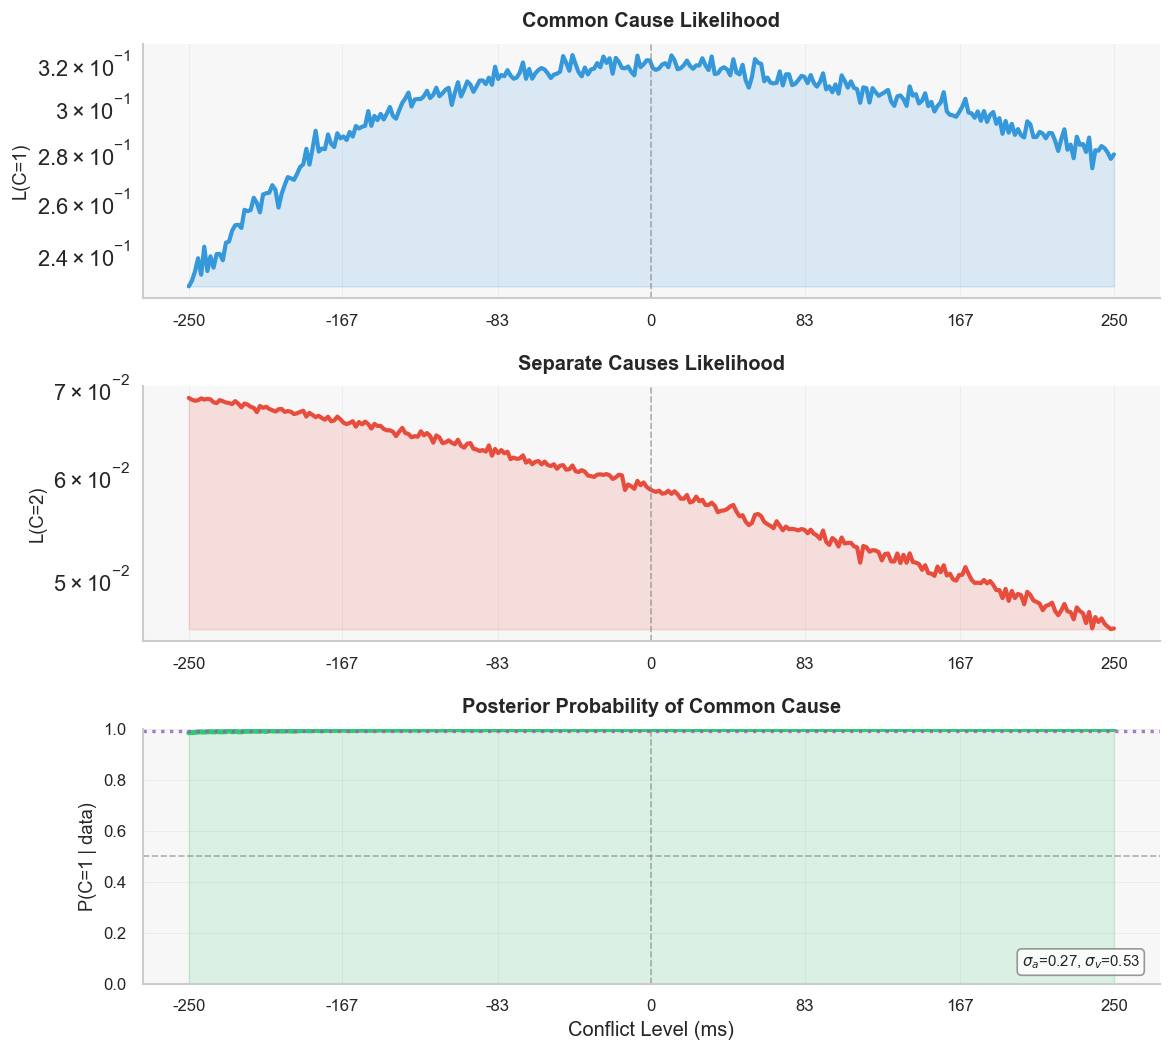

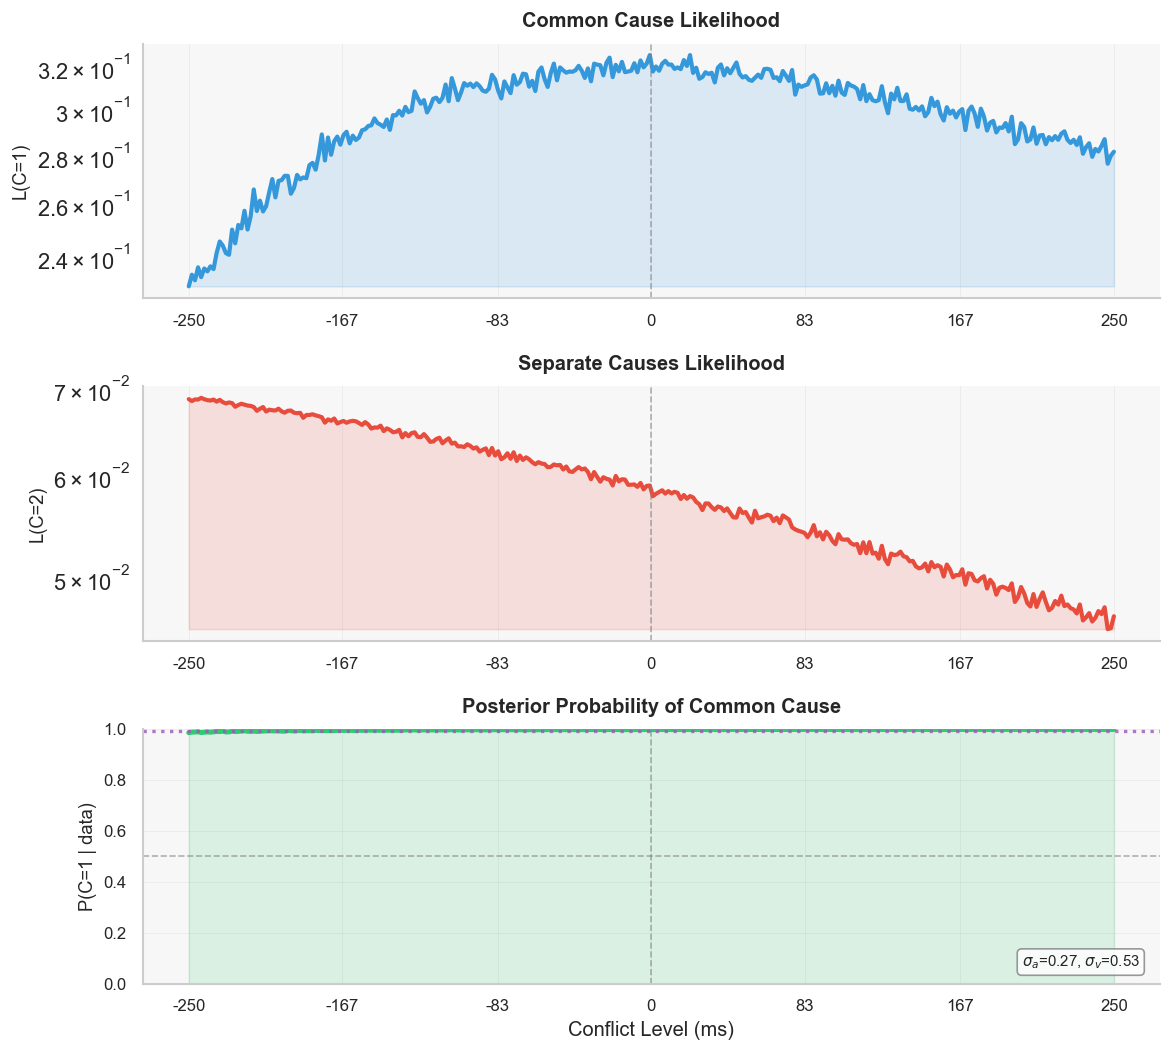

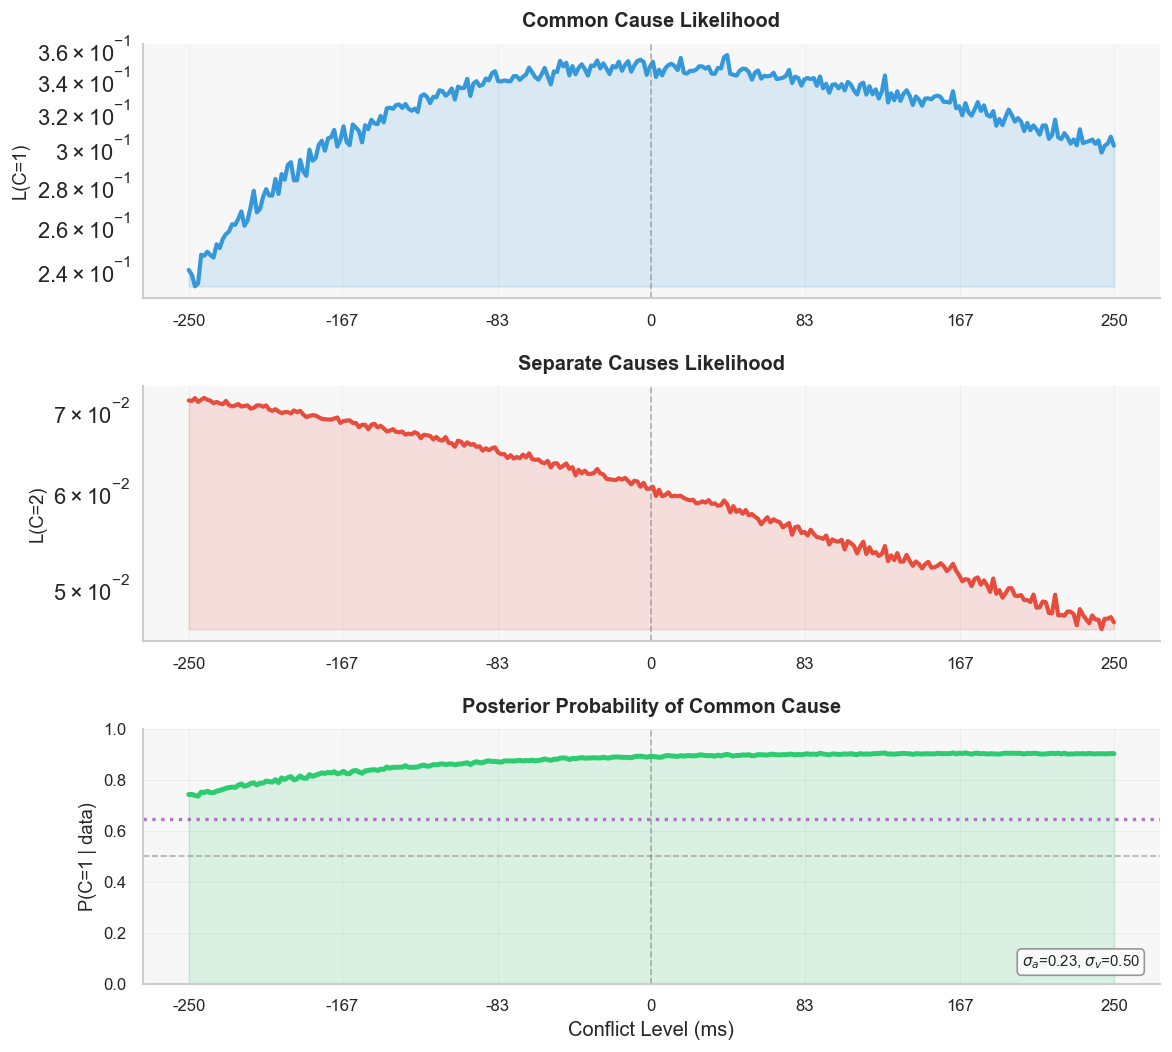

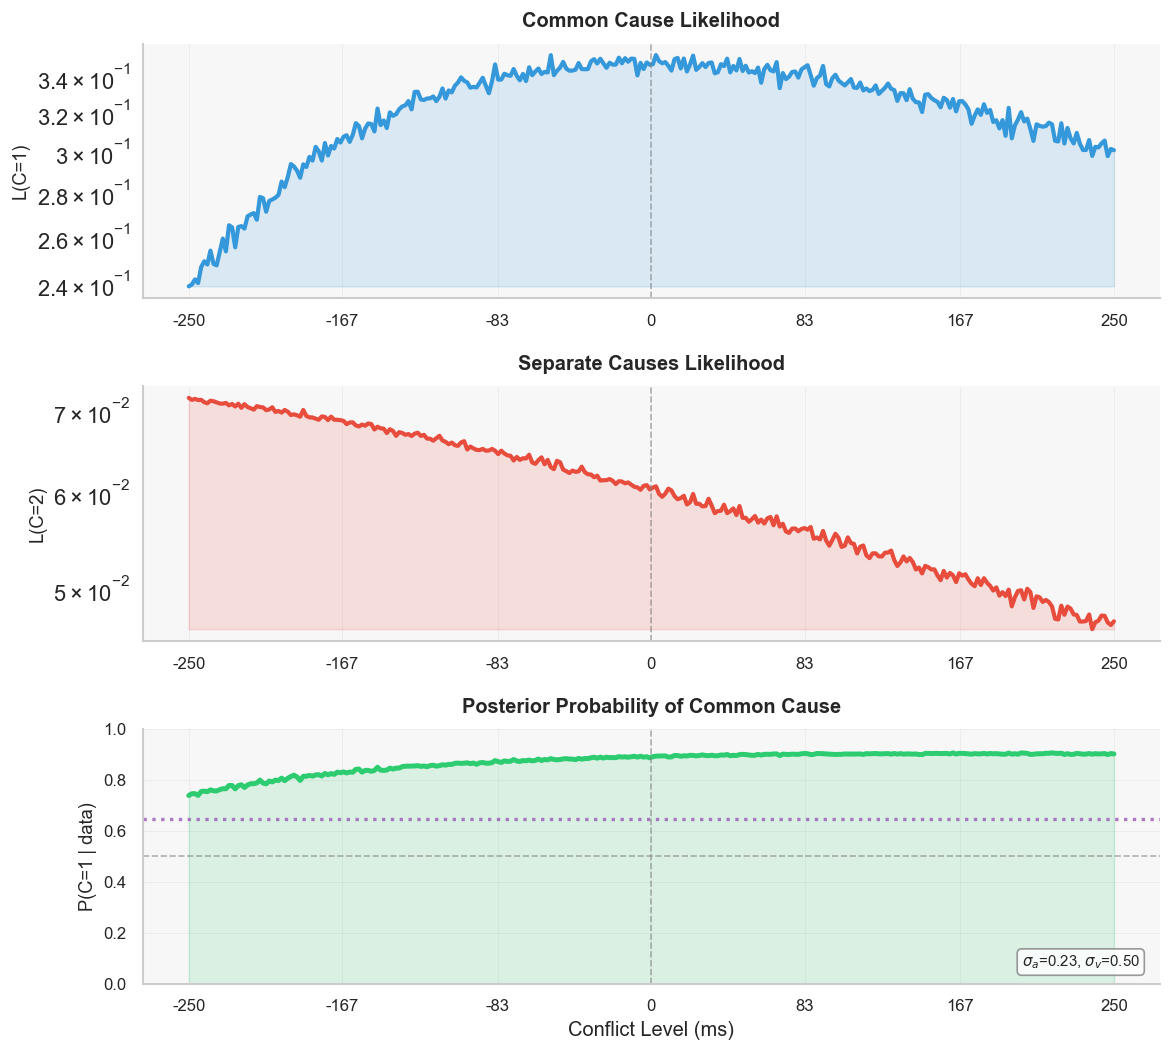

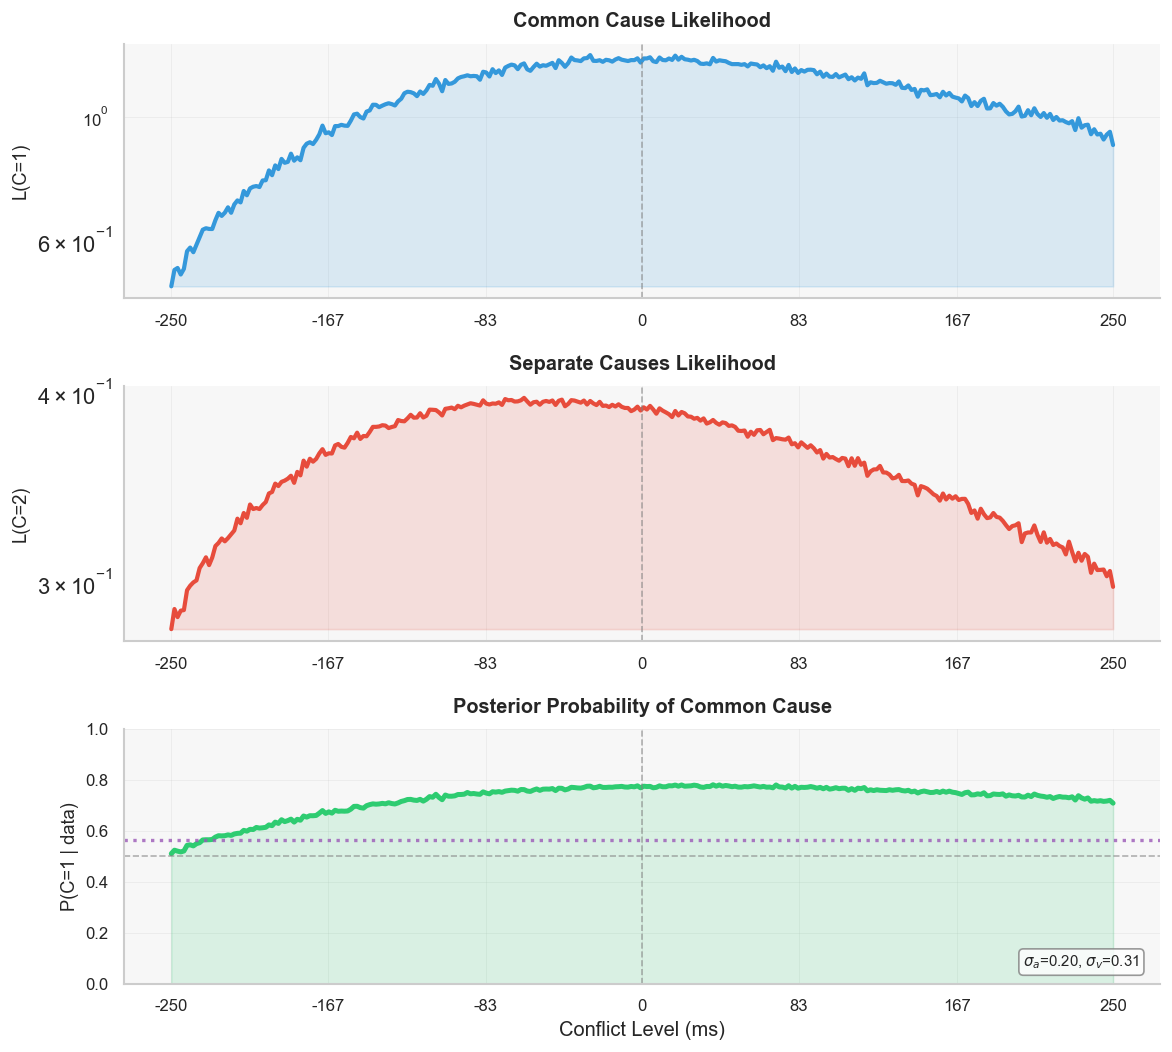

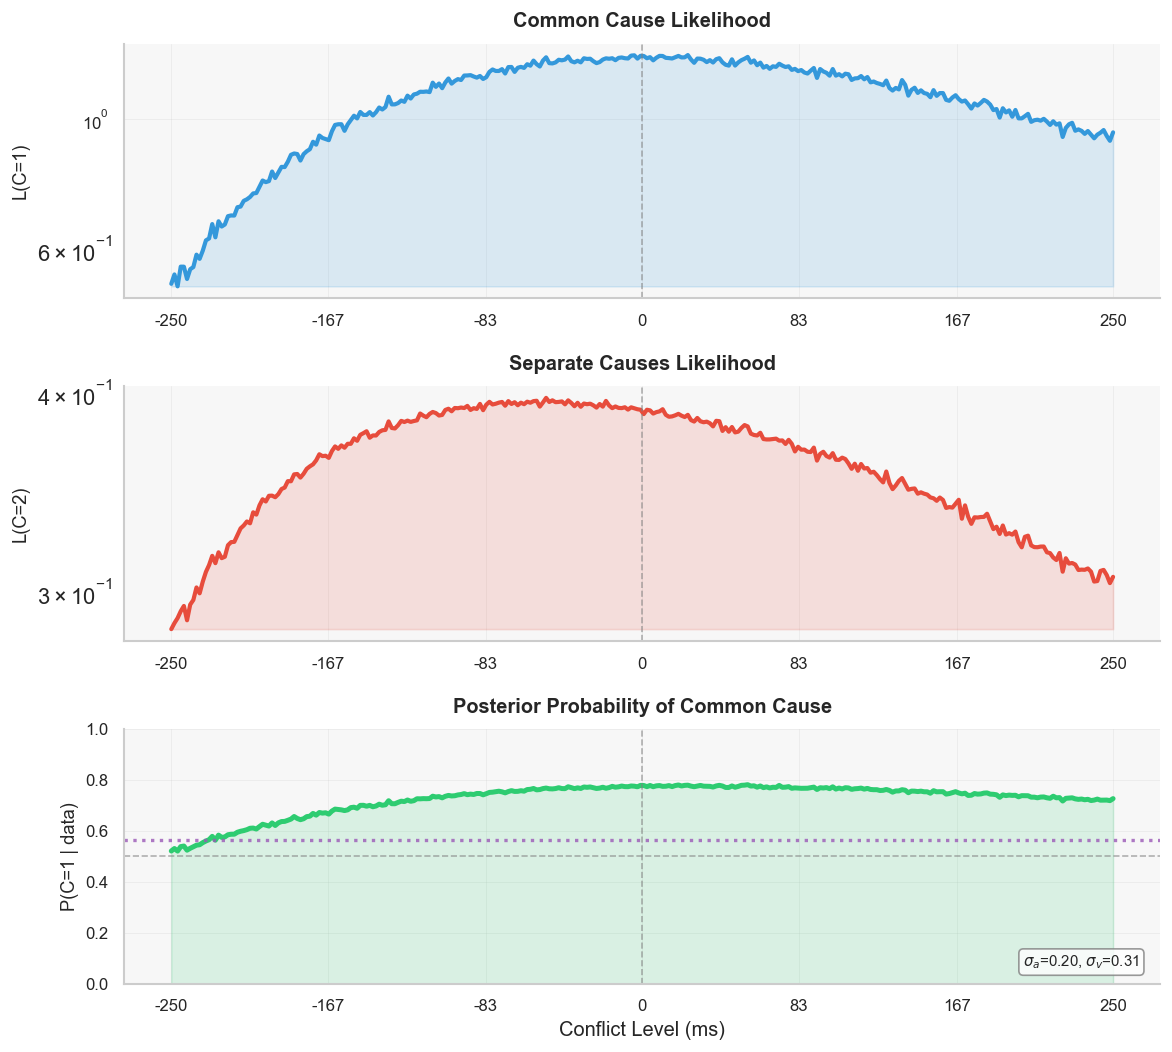

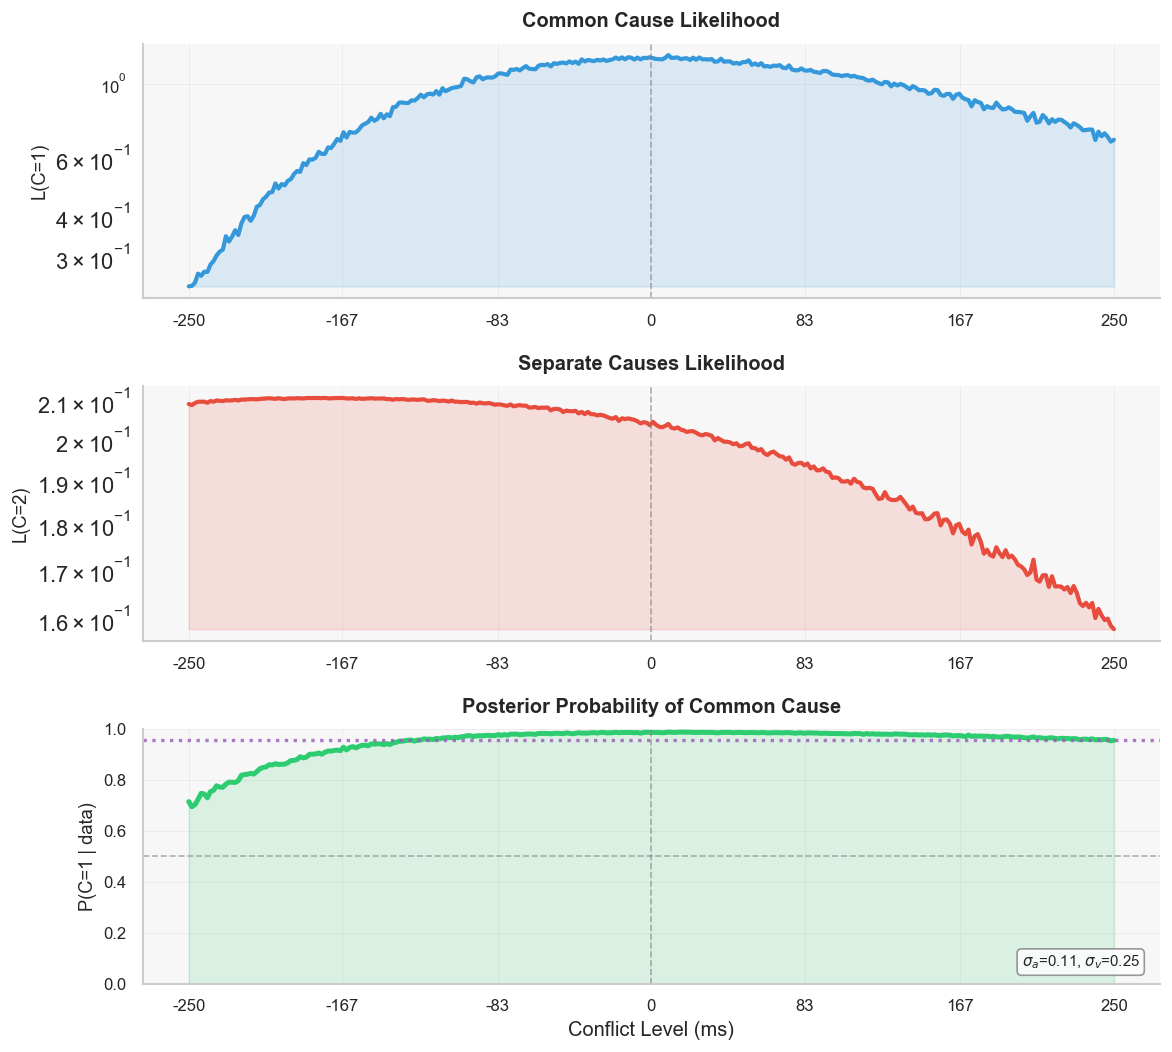

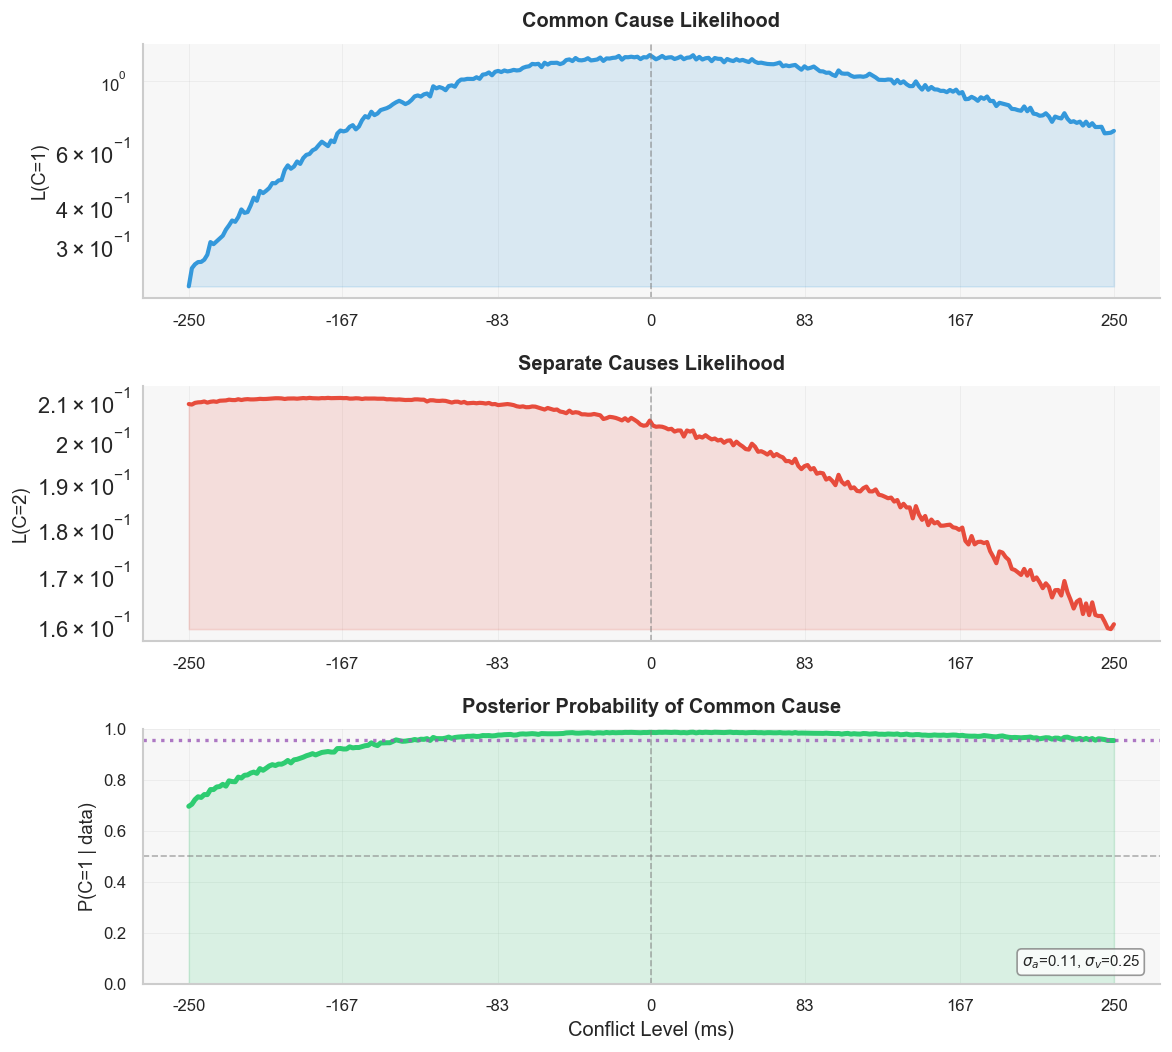

In [35]:
# Plot posterior per participants
import matplotlib.pyplot as plt
from bootstrapperSaveLoad import saveBootstrappedParams, loadBootstrappedParams
import loadResults
import os
import json
import seaborn as sns


def plotPosteriorsPerSubj(participantIds, modelTypes, parameterToPLot="mu"):

    lenSubjs=len(participantIds)
    lenModels=len(modelTypes)
    plt.figure(figsize=(8,6*lenSubjs))
    for pNum,participantID in enumerate(participantIds):
        
        for modelType in ["lognorm"]:#modelTypes:
            modelType=modelType.split("_")[0]

            # 4 - read monte carlo fit results
            # 4.1 read data
            data, dataName = loadData.loadData(participantID+"_all.csv", verbose=False)
            
            mc_fitter = monteCarloClass.OmerMonteCarlo(data)
            t_min_data=mc_fitter.data_t_min
            t_max_data=mc_fitter.data_t_max
            mc_fitter.modelName = modelType
            mc_fitter.freeP_c = False
            mc_fitter.sharedLambda = False
            mc_fitter.dataName = dataName 
            res=loadResults.loadFitResults(mc_fitter,dataName, modelName=mc_fitter.modelName)
            print(f"Loaded saved fit results: {res}")
            mc_fitter.modelFit= res['fittedParams']
            mc_fitter.logLikelihood= res['logLikelihood']
            mc_fitter.aic= res['AIC']
            mc_fitter.bic= res['BIC']
            mc_fitter.nDataPoints= res['n_conditions']

            # plt.text(-1,0.4,f" Subj: {participantID},  Model: {modelType}")
            # for i in range(len(mc_fitter.modelFit)):
            #     plt.text(-1,0.35-(i*0.05),f" Param {i}: {mc_fitter.modelFit[i]:.4f}")
            # proceed to plot all fits together
            
            sigma_a= mc_fitter.modelFit[1]
            sigma_v= mc_fitter.modelFit[2]
            p_c= mc_fitter.modelFit[3]
            sigma_a2= mc_fitter.modelFit[4]
            lambda_2= mc_fitter.modelFit[5]
            lambda_3= mc_fitter.modelFit[6]
            #plt.subplot(lenSubjs,2 ,(pNum+1))
            #plt.title(f"Participant: {participantID}")
            print(50*"-")
            print(f"Participant: {participantID}, sigma_a: {sigma_a}, sigma_v: {sigma_v}, p_c: {p_c}, sigma_a2: {sigma_a2}, lambda_2: {lambda_2}, lambda_3: {lambda_3}")
            print(50*"-")
            for j, audioNoiseLevel in enumerate(sorted(mc_fitter.uniqueSensory)):
                plot_likelihood_components(sigma_a=sigma_a, sigma_v=sigma_v, p_c=p_c, t_min=t_min_data, t_max=t_max_data, measurement="log-space")
            

            

plotPosteriorsPerSubj(participantIds[:4], modelTypes, parameterToPLot="mu")              

# Unimodal psychometric fits and predicted fits

In [36]:
modelTypes

['fusionOnlyLogNorm_sharedPrior',
 'logLinearMismatch_sharedPrior',
 'lognorm_sharedPrior',
 'probabilityMatchingLogNorm_sharedPrior',
 'selection_sharedPrior',
 'switchingFree_sharedPrior']

Loaded real data psychometric fit for all from psychometric_fits_real/all/all_psychometricFits.json
Loaded simulated data psychometric fit for all, model lognorm from psychometric_fits_simulated/all/all_lognorm_psychometricFits.json✅
Loaded saved fit results: {'participantID': 'all', 'modelType': 'lognorm_LapseFree_sharedPrior', 'fittedParams': [0.1148295617881552, 0.26510078233769274, 0.5252749505013505, 0.9944184451434158, 0.568894575886471, 0.09512338326531265, 0.17045617522356135], 'AIC': 25336.161906657137, 'BIC': 25382.38164859882, 'logLikelihood': -12661.080953328568, 'n_conditions': 5447}
[0.14607833747544183, 0.11484320405899716, 0.18444107147422567, 0.2710020612427595, 0.1584561025903902, -0.1588964378898503, -0.10944863779822307, -0.0021506924085651848, 0.041315050353740494, 0.10103447200513085, 0.1074849977308987, 0.13090042805641935, -0.04271356024717934, -0.01808469178065553, 0.013017813258570796, 0.011945128690030539, 0.013064989774131772, 0.03533842571051217, 0.04665169

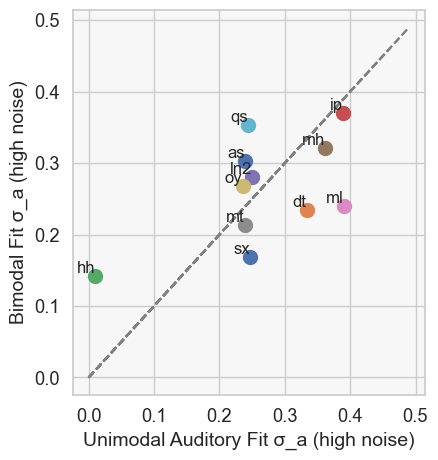

In [37]:
import scipy.io
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)

# unimodal psychometric fits and predicted fits
for pNum,participantID in enumerate(participantIds):
    # import forced fusion model simulation fit
    for modelType in ["lognorm"]:#modelTypes:
        modelType=modelType.split("_")[0]
        # 1- read psychometric fits for real data
        real_fit_path = os.path.join("psychometric_fits_real", participantID.split('_')[0], f"{participantID}_psychometricFits.json")
        try:
            with open(real_fit_path, 'r') as f:
                real_fit = json.load(f)
                print(f"Loaded real data psychometric fit for {participantID} from {real_fit_path}")
        except Exception as e:
            print(f"Error loading real data psychometric fit for {participantID}: {e}")
            continue

        #print(f"Real fit params: {real_fit['fitParams']}\n\n\n")


        # 2- read psychometric fits for simulated data
        sim_fit_path = os.path.join("psychometric_fits_simulated", participantID.split('_')[0], f"{participantID}_{modelType}_psychometricFits.json")
        try:
            with open(sim_fit_path, 'r') as f:
                sim_fit = json.load(f)
            print(f"Loaded simulated data psychometric fit for {participantID}, model {modelType} from {sim_fit_path}✅")
#            print(f"Simulated fit params: {sim_fit['fitParams']}")
        except Exception as e:
            print(f"Error loading simulated data psychometric fit for {participantID}, model {modelType}: {e}\n❗")
            continue
        


        # 4 - read monte carlo fit results
        # 4.1 read data
        data, dataName = loadData.loadData(participantID+"_all.csv", verbose=False)
        mc_fitter = monteCarloClass.OmerMonteCarlo(data)
        mc_fitter.modelName = modelType
        mc_fitter.freeP_c = False
        mc_fitter.sharedLambda = False
        mc_fitter.dataName = dataName 
        res=loadResults.loadFitResults(mc_fitter,dataName, modelName=mc_fitter.modelName)
        print(f"Loaded saved fit results: {res}")
        mc_fitter.modelFit= res['fittedParams']
        mc_fitter.logLikelihood= res['logLikelihood']
        mc_fitter.aic= res['AIC']
        mc_fitter.bic= res['BIC']
        mc_fitter.nDataPoints= res['n_conditions']

        print(real_fit["fitParams"])
        sigma_a_real_high = mc_fitter.getParams(real_fit["fitParams"], 0, 1.2)[2]
        print(f"\n\n\nsigma_a_real_high: {sigma_a_real_high}\n\n\n")
        sigma_a_real_low = mc_fitter.getParams(real_fit["fitParams"], 0, 0.1)[2]


        #print(f"\n\nParticipant: {participantID}, MC fitted sigma_a high noise: {sigma_a_real_high}\n\n\n")


        # 5- Read unimodal fits
        # unimodal auditory fits
        # join /data/ to path
        # load matlab file
        auditory_fit_path = os.path.join("data", f"{participantID}_auditory_fits.mat")
        try:
            auditory_fit_data = scipy.io.loadmat(auditory_fit_path)
            auditory_fit_params = auditory_fit_data['fittedParams'].flatten()
            print(50*"-")
            #print(f"Participant: {participantID}, Auditory fit params: {auditory_fit_params}")
            #print(f"sigma_a_high: {auditory_fit_params[1]}, sigma_a_low: {auditory_fit_params[2]}")
            #print(f"Loaded auditory fit params for {participantID} from {auditory_fit_path}: {auditory_fit_params}")
        except Exception as e:
            print(f"Error loading auditory fit params for {participantID} from {auditory_fit_path}: {e}\n❗")
            continue


        # visual unimodal fits
        visual_fit_path = os.path.join("data", f"{participantID}_visual_fits.mat")
        try:
            visual_fit_data = scipy.io.loadmat(visual_fit_path)
            visual_fit_params = visual_fit_data['fittedParams'].flatten()
            #print(f"Participant: {participantID}, Visual fit params: {visual_fit_params}")
            #print(f"sigma_v: {visual_fit_params[1]}")
            #print(f"Loaded visual fit params for {participantID} from {visual_fit_path}: {visual_fit_params}")
        except Exception as e:
            print(f"Error loading visual fit params for {participantID} from {visual_fit_path}: {e}\n❗")
            continue

        # 6 - Compare unimodal sigmas to MC fit sigmas
        sigma_a_mc_low = mc_fitter.modelFit[1]
        sigma_a_mc_high = mc_fitter.modelFit[4]
        sigma_v_mc = mc_fitter.modelFit[4]
        print(50*"-")
        print(f"Participant: {participantID}")
        
        # scatter plot auditory high to MC fit high noise auditory sigma
        #
        plt.scatter(auditory_fit_params[2], sigma_a_real_high, label=f"{participantID}", s=100)
        #as text draw the participantID next to the point
        plt.text(auditory_fit_params[2], sigma_a_real_high, participantID, fontsize=12, ha='right', va='bottom')
        plt.xlabel("Unimodal Auditory Fit σ_a (high noise)", fontsize=14)
        plt.ylabel("Bimodal Fit σ_a (high noise)", fontsize=14)
        # draw unity line
        plt.plot([0, max(auditory_fit_params[2], sigma_a_real_high)+0.1], [0, max(auditory_fit_params[2], sigma_a_real_high)+0.1], color='gray', linestyle='--')
        #plt.plot([0, max(auditory_fit_params[2], sigma_a_mc_high)+0.1], [0, max(auditory_fit_params[2], sigma_a_mc _high)+0.1], color='gray', linestyle='--')
        



            


In [38]:
modelTypes

['fusionOnlyLogNorm_sharedPrior',
 'logLinearMismatch_sharedPrior',
 'lognorm_sharedPrior',
 'probabilityMatchingLogNorm_sharedPrior',
 'selection_sharedPrior',
 'switchingFree_sharedPrior']

Error loading auditory fits for all: [Errno 2] No such file or directory: 'data/all_auditory_fits.mat'
Error loading auditory fits for ln1: [Errno 2] No such file or directory: 'data/ln1_auditory_fits.mat'


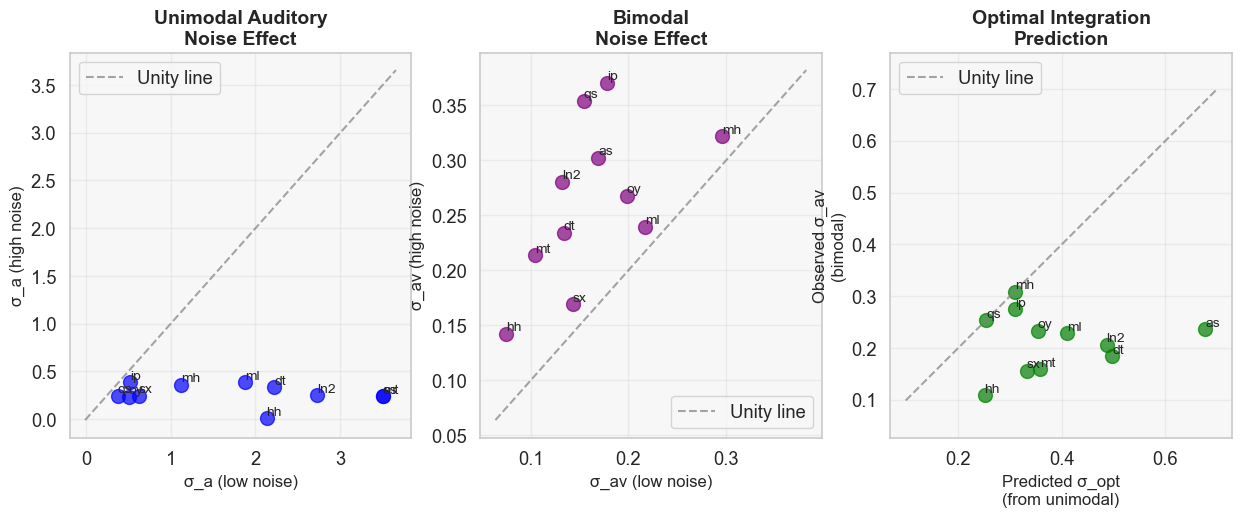

Text(0.5, 1.02, 'Noise Effects and Optimal Integration Analysis')

<Figure size 640x480 with 0 Axes>

In [39]:
import scipy.io
plt.figure(figsize=(15, 5))

# More meaningful sigma comparison: 
# 1. Auditory noise effect (unimodal high vs low)
# 2. Bimodal noise effect (sigma_av high vs low)
# 3. Predicted optimal integration vs observed bimodal sigma_av

for pNum, participantID in enumerate(participantIds):
    for modelType in ["fusionOnlyLogNorm"]:
        modelType = modelType.split("_")[0]
        
        # 1- Load real data psychometric fits
        real_fit_path = os.path.join("psychometric_fits_real", participantID.split('_')[0], f"{participantID}_psychometricFits.json")
        try:
            with open(real_fit_path, 'r') as f:
                real_fit = json.load(f)
        except Exception as e:
            print(f"Error loading real fit for {participantID}: {e}")
            continue

        # 2- Load Monte Carlo fit results
        data, dataName = loadData.loadData(participantID + "_all.csv", verbose=False)
        mc_fitter = monteCarloClass.OmerMonteCarlo(data)
        mc_fitter.modelName = modelType
        mc_fitter.freeP_c = False
        mc_fitter.sharedLambda = False
        mc_fitter.dataName = dataName 
        res = loadResults.loadFitResults(mc_fitter, dataName, modelName=mc_fitter.modelName)
        mc_fitter.modelFit = res['fittedParams']

        # Extract COMBINED bimodal fit sigmas (sigma_av) for high and low noise conditions
        sigma_av_high = mc_fitter.getParams(real_fit["fitParams"], 0, 1.2)[2]  # Combined sigma_av at high noise
        sigma_av_low = mc_fitter.getParams(real_fit["fitParams"], 0, 0.1)[2]   # Combined sigma_av at low noise

        # 3- Load unimodal auditory fits
        auditory_fit_path = os.path.join("data", f"{participantID}_auditory_fits.mat")
        try:
            auditory_fit_data = scipy.io.loadmat(auditory_fit_path)
            auditory_fit_params = auditory_fit_data['fittedParams'].flatten()
            sigma_a_high = auditory_fit_params[2]  # High noise
            sigma_a_low = auditory_fit_params[1]   # Low noise
        except Exception as e:
            print(f"Error loading auditory fits for {participantID}: {e}")
            continue

        # 4- Load unimodal visual fits
        visual_fit_path = os.path.join("data", f"{participantID}_visual_fits.mat")
        try:
            visual_fit_data = scipy.io.loadmat(visual_fit_path)
            visual_fit_params = visual_fit_data['fittedParams'].flatten()
            sigma_v = visual_fit_params[1]
        except Exception as e:
            print(f"Error loading visual fits for {participantID}: {e}")
            continue

        # Convert task uncertainties to sensory uncertainties (2IFC: divide by sqrt(2))
        sigma_a_high_sensory = sigma_a_high / np.sqrt(2)
        sigma_a_low_sensory = sigma_a_low / np.sqrt(2)
        sigma_v_sensory = sigma_v / np.sqrt(2)
        
        # Calculate predicted optimal integration using sensory uncertainties
        # sigma_opt_sensory = 1/sqrt(1/sigma_a_sensory^2 + 1/sigma_v_sensory^2)
        sigma_opt_high_sensory = 1 / np.sqrt(1/sigma_a_high_sensory**2 + 1/sigma_v_sensory**2)
        sigma_opt_low_sensory = 1 / np.sqrt(1/sigma_a_low_sensory**2 + 1/sigma_v_sensory**2)
        
        # Convert optimal predictions to task level (2IFC: multiply by sqrt(2))
        sigma_opt_high = sigma_opt_high_sensory * np.sqrt(2)
        sigma_opt_low = sigma_opt_low_sensory * np.sqrt(2)

        # Plot 1: Auditory noise effect (high vs low) - Unimodal
        plt.subplot(1, 3, 1)
        plt.scatter(sigma_a_low, sigma_a_high, s=100, alpha=0.7, color='blue')
        plt.text(sigma_a_low, sigma_a_high, participantID, 
                fontsize=10, ha='left', va='bottom')
        
        # Plot 2: Auditory noise effect in Bimodal (high vs low)
        plt.subplot(1, 3, 2)
        plt.scatter(sigma_av_low, sigma_av_high, s=100, alpha=0.7, color='purple')
        plt.text(sigma_av_low, sigma_av_high, participantID,
                fontsize=10, ha='left', va='bottom')
        
        # Plot 3: Predicted optimal vs observed (average across both conditions)
        sigma_opt_avg = (sigma_opt_high + sigma_opt_low) / 2
        sigma_av_avg = (sigma_av_high + sigma_av_low) / 2
        plt.subplot(1, 3, 3)
        plt.scatter(sigma_opt_avg, sigma_av_avg, s=100, alpha=0.7, color='green')
        plt.text(sigma_opt_avg, sigma_av_avg, participantID,
                fontsize=10, ha='left', va='bottom')

# Format plots
for i, (title, xlabel, ylabel) in enumerate([
    ("Unimodal Auditory\nNoise Effect", "σ_a (low noise)", "σ_a (high noise)"),
    ("Bimodal\nNoise Effect", "σ_av (low noise)", "σ_av (high noise)"), 
    ("Optimal Integration\nPrediction", "Predicted σ_opt\n(from unimodal)", "Observed σ_av\n(bimodal)")
], 1):
    
    plt.subplot(1, 3, i)
    plt.title(title, fontsize=14, fontweight='bold')
    plt.xlabel(xlabel, fontsize=12)
    plt.ylabel(ylabel, fontsize=12)
    
    # Add unity line
    xlims = plt.xlim()
    ylims = plt.ylim()
    max_val = max(xlims[1], ylims[1])
    min_val = min(xlims[0], ylims[0])
    plt.plot([min_val, max_val], [min_val, max_val], 
             color='gray', linestyle='--', alpha=0.7, label='Unity line')
    
    plt.grid(True, alpha=0.3)
    plt.legend()
    
    # Make axes equal for better comparison


plt.axis('equal')
plt.show()
    

plt.tight_layout()
plt.suptitle('Noise Effects and Optimal Integration Analysis', fontsize=13, y=1.02)

Error loading auditory fits for all: [Errno 2] No such file or directory: 'data/all_auditory_fits.mat'
Error loading auditory fits for ln1: [Errno 2] No such file or directory: 'data/ln1_auditory_fits.mat'


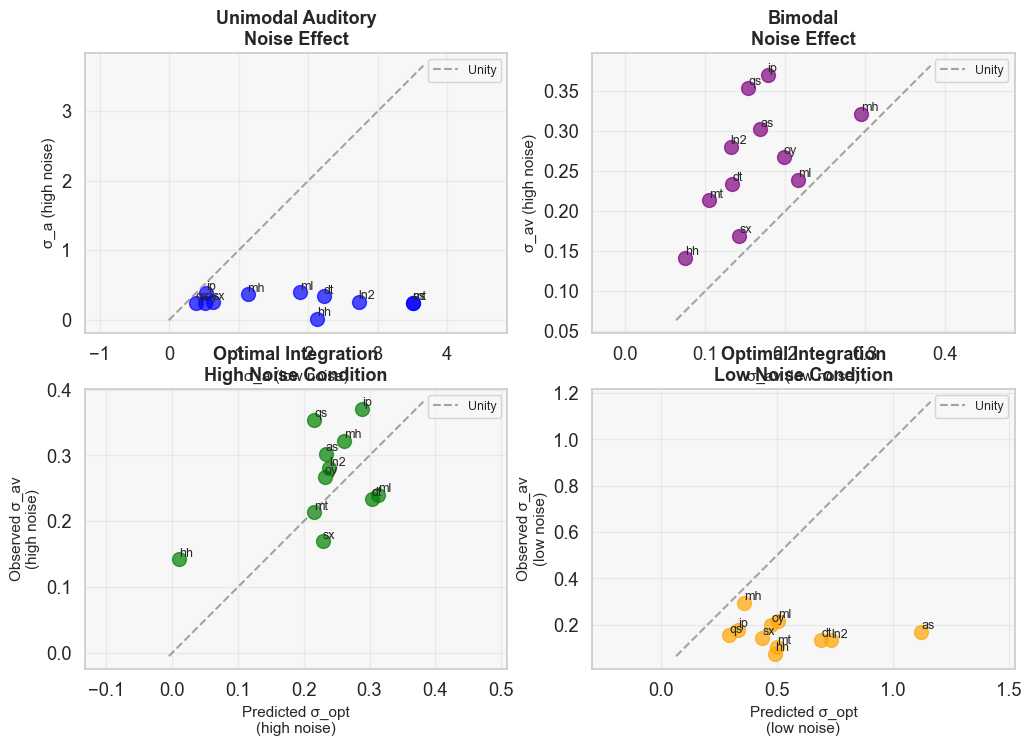

Text(0.5, 1.0, 'Noise Effects and Optimal Integration by Condition')

<Figure size 640x480 with 0 Axes>

In [40]:
import scipy.io
plt.figure(figsize=(12, 8))  # 2x2 layout

# Comprehensive noise and integration analysis

for pNum, participantID in enumerate(participantIds):
    for modelType in ["fusionOnlyLogNorm"]:
        modelType = modelType.split("_")[0]
        
        # 1- Load real data psychometric fits
        real_fit_path = os.path.join("psychometric_fits_real", participantID.split('_')[0], f"{participantID}_psychometricFits.json")
        try:
            with open(real_fit_path, 'r') as f:
                real_fit = json.load(f)
        except Exception as e:
            print(f"Error loading real fit for {participantID}: {e}")
            continue

        # 2- Load Monte Carlo fit results
        data, dataName = loadData.loadData(participantID + "_all.csv", verbose=False)
        mc_fitter = monteCarloClass.OmerMonteCarlo(data)
        mc_fitter.modelName = modelType
        mc_fitter.freeP_c = False
        mc_fitter.sharedLambda = False
        mc_fitter.dataName = dataName 
        res = loadResults.loadFitResults(mc_fitter, dataName, modelName=mc_fitter.modelName)
        mc_fitter.modelFit = res['fittedParams']

        # Extract COMBINED bimodal fit sigmas (sigma_av)
        sigma_av_high = mc_fitter.getParams(real_fit["fitParams"], 0, 1.2)[2]  
        sigma_av_low = mc_fitter.getParams(real_fit["fitParams"], 0, 0.1)[2]   

        # Extract model-fitted sigmas
        sigma_av_model_high = mc_fitter.getParamsCausal(mc_fitter.modelFit, 1.2, 0)[1]
        sigma_av_model_low = mc_fitter.getParamsCausal(mc_fitter.modelFit, 0.1, 0)[1]

        # 3- Load unimodal auditory fits
        auditory_fit_path = os.path.join("data", f"{participantID}_auditory_fits.mat")
        try:
            auditory_fit_data = scipy.io.loadmat(auditory_fit_path)
            auditory_fit_params = auditory_fit_data['fittedParams'].flatten()
            sigma_a_high = auditory_fit_params[2]  
            sigma_a_low = auditory_fit_params[1]   
        except Exception as e:
            print(f"Error loading auditory fits for {participantID}: {e}")
            continue

        # 4- Load unimodal visual fits
        visual_fit_path = os.path.join("data", f"{participantID}_visual_fits.mat")
        try:
            visual_fit_data = scipy.io.loadmat(visual_fit_path)
            visual_fit_params = visual_fit_data['fittedParams'].flatten()
            sigma_v = visual_fit_params[1]
        except Exception as e:
            print(f"Error loading visual fits for {participantID}: {e}")
            continue

        # Convert task uncertainties to sensory uncertainties (2IFC: divide by sqrt(2))
        sigma_a_high_sensory = sigma_a_high / np.sqrt(2)
        sigma_a_low_sensory = sigma_a_low / np.sqrt(2)
        sigma_v_sensory = sigma_v / np.sqrt(2)
        
        # Calculate predicted optimal integration using sensory uncertainties
        sigma_opt_high_sensory = 1 / np.sqrt(1/sigma_a_high_sensory**2 + 1/sigma_v_sensory**2)
        sigma_opt_low_sensory = 1 / np.sqrt(1/sigma_a_low_sensory**2 + 1/sigma_v_sensory**2)
        
        # Convert optimal predictions to task level (2IFC: multiply by sqrt(2))
        sigma_opt_high = sigma_opt_high_sensory * np.sqrt(2)
        sigma_opt_low = sigma_opt_low_sensory * np.sqrt(2)

        # Plot 1: Unimodal auditory noise effect
        plt.subplot(2, 2, 1)
        plt.scatter(sigma_a_low, sigma_a_high, s=100, alpha=0.7, color='blue')
        plt.text(sigma_a_low, sigma_a_high, participantID, 
                fontsize=9, ha='left', va='bottom')
        
        # Plot 2: Bimodal noise effect
        plt.subplot(2, 2, 2)
        plt.scatter(sigma_av_low, sigma_av_high, s=100, alpha=0.7, color='purple')
        plt.text(sigma_av_low, sigma_av_high, participantID,
                fontsize=9, ha='left', va='bottom')
        
        # Plot 3: Optimal prediction vs observed (high noise)
        plt.subplot(2, 2, 3)
        plt.scatter(sigma_opt_high, sigma_av_high, s=100, alpha=0.7, color='green')
        plt.text(sigma_opt_high, sigma_av_high, participantID,
                fontsize=9, ha='left', va='bottom')
        
        # Plot 4: Optimal prediction vs observed (low noise)
        plt.subplot(2, 2, 4)
        plt.scatter(sigma_opt_low, sigma_av_low, s=100, alpha=0.7, color='orange')
        plt.text(sigma_opt_low, sigma_av_low, participantID,
                fontsize=9, ha='left', va='bottom')

# Format plots
for i, (title, xlabel, ylabel) in enumerate([
    ("Unimodal Auditory\nNoise Effect", "σ_a (low noise)", "σ_a (high noise)"),
    ("Bimodal\nNoise Effect", "σ_av (low noise)", "σ_av (high noise)"), 
    ("Optimal Integration\nHigh Noise Condition", "Predicted σ_opt\n(high noise)", "Observed σ_av\n(high noise)"),
    ("Optimal Integration\nLow Noise Condition", "Predicted σ_opt\n(low noise)", "Observed σ_av\n(low noise)")
], 1):
    
    plt.subplot(2, 2, i)
    plt.title(title, fontsize=13, fontweight='bold')
    plt.xlabel(xlabel, fontsize=11)
    plt.ylabel(ylabel, fontsize=11)
    
    # Add unity line
    xlims = plt.xlim()
    ylims = plt.ylim()
    max_val = max(xlims[1], ylims[1])
    min_val = min(xlims[0], ylims[0])
    plt.plot([min_val, max_val], [min_val, max_val], 
             color='gray', linestyle='--', alpha=0.7, label='Unity')
    
    plt.grid(True, alpha=0.3)
    plt.legend(fontsize=9)
    plt.axis('equal')

plt.show()

plt.tight_layout()            
plt.suptitle('Noise Effects and Optimal Integration by Condition',  fontsize=13, y=1.00)

Error loading auditory fits for all: [Errno 2] No such file or directory: 'data/all_auditory_fits.mat'
Error loading auditory fits for ln1: [Errno 2] No such file or directory: 'data/ln1_auditory_fits.mat'


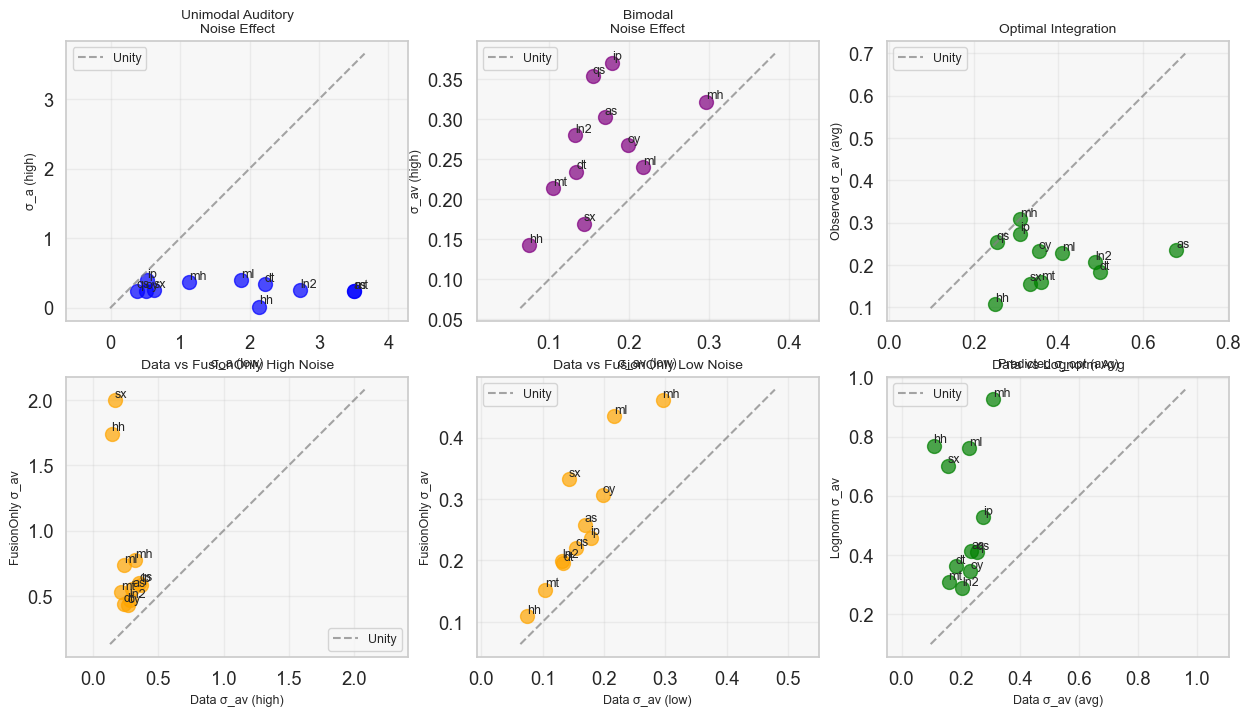

Text(0.5, 1.0, 'Comprehensive Sigma Analysis: Noise Effects, Optimal Integration & Model Fits')

<Figure size 640x480 with 0 Axes>

In [41]:
import scipy.io
plt.figure(figsize=(15, 8))  # 2 rows x 3 columns

# Comprehensive analysis: Noise effects, Optimal integration, and Model comparisons

for pNum, participantID in enumerate(participantIds):
    for modelType in ["fusionOnlyLogNorm"]:
        modelType = modelType.split("_")[0]
        
        # 1- Load real data psychometric fits
        real_fit_path = os.path.join("psychometric_fits_real", participantID.split('_')[0], f"{participantID}_psychometricFits.json")
        try:
            with open(real_fit_path, 'r') as f:
                real_fit = json.load(f)
        except Exception as e:
            print(f"Error loading real fit for {participantID}: {e}")
            continue

        # 2- Load Monte Carlo fit results
        data, dataName = loadData.loadData(participantID + "_all.csv", verbose=False)
        mc_fitter = monteCarloClass.OmerMonteCarlo(data)
        mc_fitter.modelName = modelType
        mc_fitter.freeP_c = False
        mc_fitter.sharedLambda = False
        mc_fitter.dataName = dataName 
        res = loadResults.loadFitResults(mc_fitter, dataName, modelName=mc_fitter.modelName)
        mc_fitter.modelFit = res['fittedParams']

        # Extract COMBINED bimodal fit sigmas (sigma_av)
        sigma_av_high = mc_fitter.getParams(real_fit["fitParams"], 0, 1.2)[2]  
        sigma_av_low = mc_fitter.getParams(real_fit["fitParams"], 0, 0.1)[2]   

        # Extract FusionOnly model-fitted sigmas
        sigma_av_model_high = mc_fitter.getParamsCausal(mc_fitter.modelFit, 1.2, 0)[1]
        sigma_av_model_low = mc_fitter.getParamsCausal(mc_fitter.modelFit, 0.1, 0)[1]

        # 3- Load unimodal auditory fits
        auditory_fit_path = os.path.join("data", f"{participantID}_auditory_fits.mat")
        try:
            auditory_fit_data = scipy.io.loadmat(auditory_fit_path)
            auditory_fit_params = auditory_fit_data['fittedParams'].flatten()
            sigma_a_high = auditory_fit_params[2]  
            sigma_a_low = auditory_fit_params[1]   
        except Exception as e:
            print(f"Error loading auditory fits for {participantID}: {e}")
            continue

        # 4- Load unimodal visual fits
        visual_fit_path = os.path.join("data", f"{participantID}_visual_fits.mat")
        try:
            visual_fit_data = scipy.io.loadmat(visual_fit_path)
            visual_fit_params = visual_fit_data['fittedParams'].flatten()
            sigma_v = visual_fit_params[1]
        except Exception as e:
            print(f"Error loading visual fits for {participantID}: {e}")
            continue

        # 5- Load lognorm model results
        mc_fitter_lognorm = monteCarloClass.OmerMonteCarlo(data)
        mc_fitter_lognorm.modelName = "lognorm"
        mc_fitter_lognorm.freeP_c = False
        mc_fitter_lognorm.sharedLambda = False
        mc_fitter_lognorm.dataName = dataName 
        res_lognorm = loadResults.loadFitResults(mc_fitter_lognorm, dataName, modelName=mc_fitter_lognorm.modelName)
        mc_fitter_lognorm.modelFit = res_lognorm['fittedParams']
        
        # Extract lognorm model sigmas
        sigma_av_lognorm_high = mc_fitter_lognorm.getParamsCausal(mc_fitter_lognorm.modelFit, 1.2, 0)[1]
        sigma_av_lognorm_low = mc_fitter_lognorm.getParamsCausal(mc_fitter_lognorm.modelFit, 0.1, 0)[1]

        # Convert task uncertainties to sensory uncertainties (2IFC: divide by sqrt(2))
        sigma_a_high_sensory = sigma_a_high / np.sqrt(2)
        sigma_a_low_sensory = sigma_a_low / np.sqrt(2)
        sigma_v_sensory = sigma_v / np.sqrt(2)
        
        # Calculate predicted optimal integration using sensory uncertainties
        sigma_opt_high_sensory = 1 / np.sqrt(1/sigma_a_high_sensory**2 + 1/sigma_v_sensory**2)
        sigma_opt_low_sensory = 1 / np.sqrt(1/sigma_a_low_sensory**2 + 1/sigma_v_sensory**2)
        
        # Convert optimal predictions to task level (2IFC: multiply by sqrt(2))
        sigma_opt_high = sigma_opt_high_sensory * np.sqrt(2)
        sigma_opt_low = sigma_opt_low_sensory * np.sqrt(2)

        # FIRST ROW: Basic comparisons
        # Plot 1: Unimodal auditory noise effect
        plt.subplot(2, 3, 1)
        plt.scatter(sigma_a_low, sigma_a_high, s=100, alpha=0.7, color='blue')
        plt.text(sigma_a_low, sigma_a_high, participantID, 
                fontsize=9, ha='left', va='bottom')
        
        # Plot 2: Bimodal noise effect
        plt.subplot(2, 3, 2)
        plt.scatter(sigma_av_low, sigma_av_high, s=100, alpha=0.7, color='purple')
        plt.text(sigma_av_low, sigma_av_high, participantID,
                fontsize=9, ha='left', va='bottom')
        
        # Plot 3: Optimal prediction vs observed (averaged)
        sigma_opt_avg = (sigma_opt_high + sigma_opt_low) / 2
        sigma_av_avg = (sigma_av_high + sigma_av_low) / 2
        plt.subplot(2, 3, 3)
        plt.scatter(sigma_opt_avg, sigma_av_avg, s=100, alpha=0.7, color='green')
        plt.text(sigma_opt_avg, sigma_av_avg, participantID,
                fontsize=9, ha='left', va='bottom')

        # SECOND ROW: Model comparisons
        # Plot 4: Data vs FusionOnly (high noise)
        plt.subplot(2, 3, 4)
        plt.scatter(sigma_av_high, sigma_av_model_high, s=100, alpha=0.7, color='orange')
        plt.text(sigma_av_high, sigma_av_model_high, participantID,
                fontsize=9, ha='left', va='bottom')
        
        # Plot 5: Data vs FusionOnly (low noise)
        plt.subplot(2, 3, 5)
        plt.scatter(sigma_av_low, sigma_av_model_low, s=100, alpha=0.7, color='orange')
        plt.text(sigma_av_low, sigma_av_model_low, participantID,
                fontsize=9, ha='left', va='bottom')
        
        # Plot 6: Data vs Lognorm (averaged)
        sigma_av_lognorm_avg = (sigma_av_lognorm_high + sigma_av_lognorm_low) / 2
        plt.subplot(2, 3, 6)
        plt.scatter(sigma_av_avg, sigma_av_lognorm_avg, s=100, alpha=0.7, color='green')
        plt.text(sigma_av_avg, sigma_av_lognorm_avg, participantID,
                fontsize=9, ha='left', va='bottom')

# Format plots
# First row
for i, (title, xlabel, ylabel) in enumerate([
    ("Unimodal Auditory\nNoise Effect", "σ_a (low)", "σ_a (high)"),
    ("Bimodal\nNoise Effect", "σ_av (low)", "σ_av (high)"), 
    ("Optimal Integration", "Predicted σ_opt (avg)", "Observed σ_av (avg)")
], 1):
    
    plt.subplot(2, 3, i)
    plt.title(title, fontsize=10, )
    plt.xlabel(xlabel, fontsize=9)
    plt.ylabel(ylabel, fontsize=9)
    
    xlims = plt.xlim()
    ylims = plt.ylim()
    max_val = max(xlims[1], ylims[1])
    min_val = min(xlims[0], ylims[0])
    plt.plot([min_val, max_val], [min_val, max_val], 
             color='gray', linestyle='--', alpha=0.7, label='Unity')
    
    plt.grid(True, alpha=0.3)
    plt.legend(fontsize=9)
    plt.axis('equal')

# Second row
for i, (title, xlabel, ylabel) in enumerate([
    ("Data vs FusionOnly High Noise", "Data σ_av (high)", "FusionOnly σ_av"),
    ("Data vs FusionOnly Low Noise", "Data σ_av (low)", "FusionOnly σ_av"), 
    ("Data vs Lognorm Avg", "Data σ_av (avg)", "Lognorm σ_av")
], 4):
    
    plt.subplot(2, 3, i)
    plt.title(title, fontsize=10)
    plt.xlabel(xlabel, fontsize=9)
    plt.ylabel(ylabel, fontsize=9)
    
    xlims = plt.xlim()
    ylims = plt.ylim()
    max_val = max(xlims[1], ylims[1])
    min_val = min(xlims[0], ylims[0])
    plt.plot([min_val, max_val], [min_val, max_val], 
             color='gray', linestyle='--', alpha=0.7, label='Unity')
    
    plt.grid(True, alpha=0.3)
    plt.legend(fontsize=9)
    plt.axis('equal')

plt.show()
plt.tight_layout()            
plt.suptitle('Comprehensive Sigma Analysis: Noise Effects, Optimal Integration & Model Fits',  fontsize=13, y=1.00)

In [42]:
# Interactive plotting with model selection
import ipywidgets as widgets
from IPython.display import display, clear_output
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
def create_interactive_plot(selected_models, biasCorrection, verbose=False):
    """Create plots for selected models"""
    if not selected_models:
        print("Please select at least one model to display")
        return
    
    def _print(*args, **kwargs):
        if verbose:
            print(*args, **kwargs)
        
    with plot_output:
        clear_output(wait=True)
        
        lenSubjs = len(participantIds)
        fig, axes = plt.subplots(lenSubjs, 2, figsize=(12, 6*lenSubjs))
        if lenSubjs == 1:
            axes = axes.reshape(1, -1)
        
        for pNum, participantID in enumerate(participantIds):
            for modelType in selected_models:
                               
                # Define model labels
                model_labels = {
                    'fusionOnlyLogNorm_sharedPrior': 'Forced-Fusion (benchmark)',
                    'lognorm_sharedPrior': 'Model averaging CI',
                    'switchingFree_sharedPrior': 'Free prob. switch'
                }
                # Get the descriptive label for the model
                model_label = model_labels.get(modelType, modelType)  # Default to modelType if not in the dictionary

                modelType_clean = modelType.split("_")[0]
 
                # 1- Read psychometric fits for real data
                real_fit_path = os.path.join("psychometric_fits_real", participantID.split('_')[0], f"{participantID}_psychometricFits.json")
                try:
                    with open(real_fit_path, 'r') as f:
                        real_fit = json.load(f)
                    _print(f"Loaded real data psychometric fit for {participantID}")
                except Exception as e:
                    _print(f"Error loading real data psychometric fit for {participantID}: {e}")
                    continue

                # 2- Read psychometric fits for simulated data
                sim_fit_path = os.path.join("psychometric_fits_simulated", participantID.split('_')[0], f"{participantID}_{modelType_clean}_psychometricFits.json")
                try:
                    with open(sim_fit_path, 'r') as f:
                        sim_fit = json.load(f)
                    _print(f"Loaded simulated data psychometric fit for {participantID}, model {modelType_clean}✅")
                except Exception as e:
                    _print(f"Error loading simulated data psychometric fit for {participantID}, model {modelType_clean}: {e}")
                    continue
                
                # 3 - Read the bootstrapped fits for real data
                bootPath = participantID + "_dataFit_bootstrapped_params.json"
                dataBootsPath = os.path.join("bootstrapped_params", participantID.split('_')[0], bootPath)
                try:
                    with open(dataBootsPath, 'r') as f:
                        content = f.read().strip()
                        dataBoots = json.loads(content) if content else {}
                    _print(f"Loaded bootstrapped params for {participantID}")
                except Exception as e:
                    _print(f"Error loading bootstrapped params for {participantID}: {e}")
                    continue

                # 4 - Read monte carlo fit results
                data, dataName = loadData.loadData(participantID + "_all.csv", verbose=False)
                mc_fitter = monteCarloClass.OmerMonteCarlo(data)
                mc_fitter.modelName = modelType_clean
                mc_fitter.freeP_c = False
                mc_fitter.sharedLambda = False
                mc_fitter.dataName = dataName 
                res = loadResults.loadFitResults(mc_fitter, dataName, modelName=mc_fitter.modelName)
                _print(f"Loaded saved fit results for {participantID}")
                mc_fitter.modelFit = res['fittedParams']
                mc_fitter.logLikelihood = res['logLikelihood']
                mc_fitter.aic = res['AIC']
                mc_fitter.bic = res['BIC']
                mc_fitter.nDataPoints = res['n_conditions']

                # Get model color (consistent color for each model)
                model_colors = {
                    'fusionOnlyLogNorm_sharedPrior': 'red',
                    'logLinearMismatch_sharedPrior': 'blue',
                    'lognorm_sharedPrior': 'green',
                    'probabilityMatchingLogNorm_sharedPrior': 'orange',
                    'selection_sharedPrior': 'purple',
                    'switchingFree_sharedPrior': 'brown'
                }
                model_color = model_colors.get(modelType, 'black')  # Default to black if modelType is not in the dictionary
                
                # Proceed to plot all fits together
                for j, audioNoiseLevel in enumerate(sorted(mc_fitter.uniqueSensory)):
                    conflict_levels = []
                    mu_models = []

                    # Calculate baseline PSE at conflict == 0
                    baseline_pse = np.mean([mc_fitter.getParams(boot, 0, audioNoiseLevel)[1] for boot in dataBoots])
                    
                    for k, conflictLevel in enumerate(mc_fitter.uniqueConflict):
                        conflict_levels.append(conflictLevel)
                        
                        # Select the correct subplot
                        if lenSubjs == 1:
                            ax = axes[j]
                        else:
                            ax = axes[pNum, j]
                        
                        plt.sca(ax)
                        
                        if modelType == selected_models[0]:  # Only set title and plot data for first model
                            ax.set_title(f"Participant: {participantID}, Audio Noise: {audioNoiseLevel}")
                            
                            # Plot bootstrap data (only once)
                            bootMus = [mc_fitter.getParams(boot, conflictLevel, audioNoiseLevel)[1] for boot in dataBoots]
                            if biasCorrection:
                                bootMus = np.array(bootMus) - baseline_pse  # Center around baseline
                            ax.errorbar(conflictLevel, np.mean(bootMus), yerr=np.std(bootMus), 
                                      color="black", fmt='s', capsize=5, alpha=0.8, label='Data' if k == 0 else "")

                        # Plot model predictions
                        paramsSimDf = mc_fitter.getParams(sim_fit['fitParams'], conflictLevel, audioNoiseLevel)
                        muModel = paramsSimDf[1]
                        baseline_mu_model = mc_fitter.getParams(sim_fit['fitParams'], 0, audioNoiseLevel)[1]
                        if biasCorrection:
                            muModel -= baseline_mu_model  # Center around model baseline
                        mu_models.append(muModel)

                        ax.plot(conflictLevel, muModel, color=model_color,  linestyle='--', 
                               marker='o', markersize=10, alpha=0.7, label=f'{model_label}' if k == 0 else "")
                        
                        # Set common plot properties (only for first model to avoid repetition)
                        if modelType == selected_models[0]:
                            ax.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
                            ax.axvline(x=0, color='gray', linestyle='--', alpha=0.5)
                            ax.tick_params(axis='both', labelsize=12)
                            if pNum == lenSubjs - 1:  # Only add xlabel to bottom plots
                                ax.set_xlabel("Conflict (ms)", fontsize=14)
                            if j == 0:  # Only add ylabel to left plots
                                ax.set_ylabel("PSE shift (ms)", fontsize=14)

                        # Inside the create_interactive_plot function, where the plot is being created
                        # Add this block after setting up the plot properties for each subplot
                        x_ticks = [-0.25, -0.167, -0.083, 0, 0.083, 0.167, 0.25]
                        x_tick_labels = ['-0.25', '-0.167', '-0.083', '0', '0.083', '0.167', '0.25']

                        # Set the x-axis ticks and labels
                        ax.set_xticks(x_ticks)
                        ax.set_xticklabels(x_tick_labels, fontsize=12)

                        # set limits for y-axis
                        ax.set_ylim([-0.2, 0.2])

                    # Convert lists to arrays and sort them for a proper line plot
                    conflict_levels = np.array(conflict_levels)
                    mu_models = np.array(mu_models)
                    sorted_indices = np.argsort(conflict_levels)
                    conflict_levels_sorted = conflict_levels[sorted_indices]
                    mu_models_sorted = mu_models[sorted_indices]
                    
                    # Select the correct subplot for continuous line
                    if lenSubjs == 1:
                        ax = axes[j]
                    else:
                        ax = axes[pNum, j]
                    
                    ax.plot(conflict_levels_sorted, mu_models_sorted, color=model_color, alpha=0.7, linestyle='--', linewidth=3, 
                        label=f'{model_label}' if k == 0 else "")  # Use model_label in the legend
  
                    # Remove top and right spines for a cleaner look
                    ax.spines['top'].set_visible(False)
                    ax.spines['right'].set_visible(False)
        
        # Add legend to the first subplot
        if lenSubjs == 1:
            axes[1].legend(loc='upper left', fontsize=10)
        else:
            axes[0, 0].legend(loc='upper left', fontsize=10)
        
        plt.tight_layout()
        plt.show()

# Create model selection checkboxes
model_checkboxes = []
for model in modelTypes:
    checkbox = widgets.Checkbox(
        value=(model == "lognorm_sharedPrior"),  # Default to first model selected
        description=model,
        disabled=False,
        layout=widgets.Layout(width='200px')
    )
    model_checkboxes.append(checkbox)

# Create update button
update_button = widgets.Button(
    description='Update Plot',
    disabled=False,
    button_style='success',
    tooltip='Click to update the plot with selected models',
)

# Create output widget for the plot
plot_output = widgets.Output()

biasCorrection=0
def on_button_click(b):
    selected_models = [checkbox.description for checkbox in model_checkboxes if checkbox.value]
    create_interactive_plot(selected_models, biasCorrection=biasCorrection)

update_button.on_click(on_button_click)

# Layout the widgets
checkbox_container = widgets.VBox(model_checkboxes)
control_panel = widgets.HBox([checkbox_container, widgets.VBox([update_button])])

print("Interactive Model Comparison Plot")
print("Select the models you want to compare and click 'Update Plot':")
display(control_panel)
display(plot_output)

# Initial plot with default selection
selected_models = [checkbox.description for checkbox in model_checkboxes if checkbox.value]
create_interactive_plot(selected_models, biasCorrection=biasCorrection)

Interactive Model Comparison Plot
Select the models you want to compare and click 'Update Plot':


Output()

# parameter recovery

In [47]:
# Load Parameter Recovery Results from JSON files
import numpy as np
import pandas as pd
import json
import os
from glob import glob

def load_recovery_results(base_dir="parameter_recovery_results", modelType="lognorm"):
    """
    Load parameter recovery results from saved JSON files.
    
    Args:
        base_dir: directory containing the recovery results
        modelType: the model type to load results for
    
    Returns:
        List of recovery result dictionaries
    """
    recovery_results = []
    
    # Find all recovery JSON files
    pattern = os.path.join(base_dir, "*", f"*_{modelType}_recovery.json")
    json_files = glob(pattern)
    
    print(f"Found {len(json_files)} recovery result files")
    
    for json_file in sorted(json_files):
        try:
            with open(json_file, 'r') as f:
                result = json.load(f)
            recovery_results.append(result)
            participantID = result.get('participantID', 'unknown')
            n_successful = result.get('n_successful', 0)
            print(f"Loaded {participantID}: {n_successful} successful recoveries")
        except Exception as e:
            print(f"Error loading {json_file}: {e}")
    
    return recovery_results

# Load the recovery results
recovery_results = load_recovery_results(modelType="lognorm")

print(f"\nTotal participants with recovery results: {len(recovery_results)}")

# Display summary
if recovery_results:
    print("\nSummary:")
    for result in recovery_results:
        pid = result['participantID']
        true_p = np.array(result['true_params'])
        recovered_p = np.array(result['recovered_params_mean'])
        print(f"{pid}: True params: {np.round(true_p, 3)}, Recovered (mean): {np.round(recovered_p, 3)}")

Found 5 recovery result files
Loaded as: 20 successful recoveries
Loaded dt: 20 successful recoveries
Loaded hh: 20 successful recoveries
Loaded ip: 20 successful recoveries
Loaded ln1: 20 successful recoveries

Total participants with recovery results: 5

Summary:
as: True params: [0.052 0.229 0.5   0.647 0.596 0.096 0.02 ], Recovered (mean): [0.076 0.224 0.493 0.601 0.59  0.115 0.038]
dt: True params: [0.3   0.198 0.306 0.565 0.527 0.23  0.219], Recovered (mean): [0.249 0.322 0.402 0.651 0.573 0.166 0.189]
hh: True params: [1.00e-03 1.09e-01 2.49e-01 9.56e-01 1.43e+00 3.60e-02 5.90e-02], Recovered (mean): [0.016 0.201 0.205 0.896 1.722 0.054 0.071]
ip: True params: [0.133 0.251 0.814 0.171 0.807 0.089 0.011], Recovered (mean): [0.153 0.245 1.74  0.59  0.751 0.096 0.034]
ln1: True params: [1.250e-01 4.450e-01 8.010e-01 8.030e-01 4.078e+00 3.000e-03 5.400e-02], Recovered (mean): [0.176 0.42  0.736 0.792 1.98  0.059 0.113]


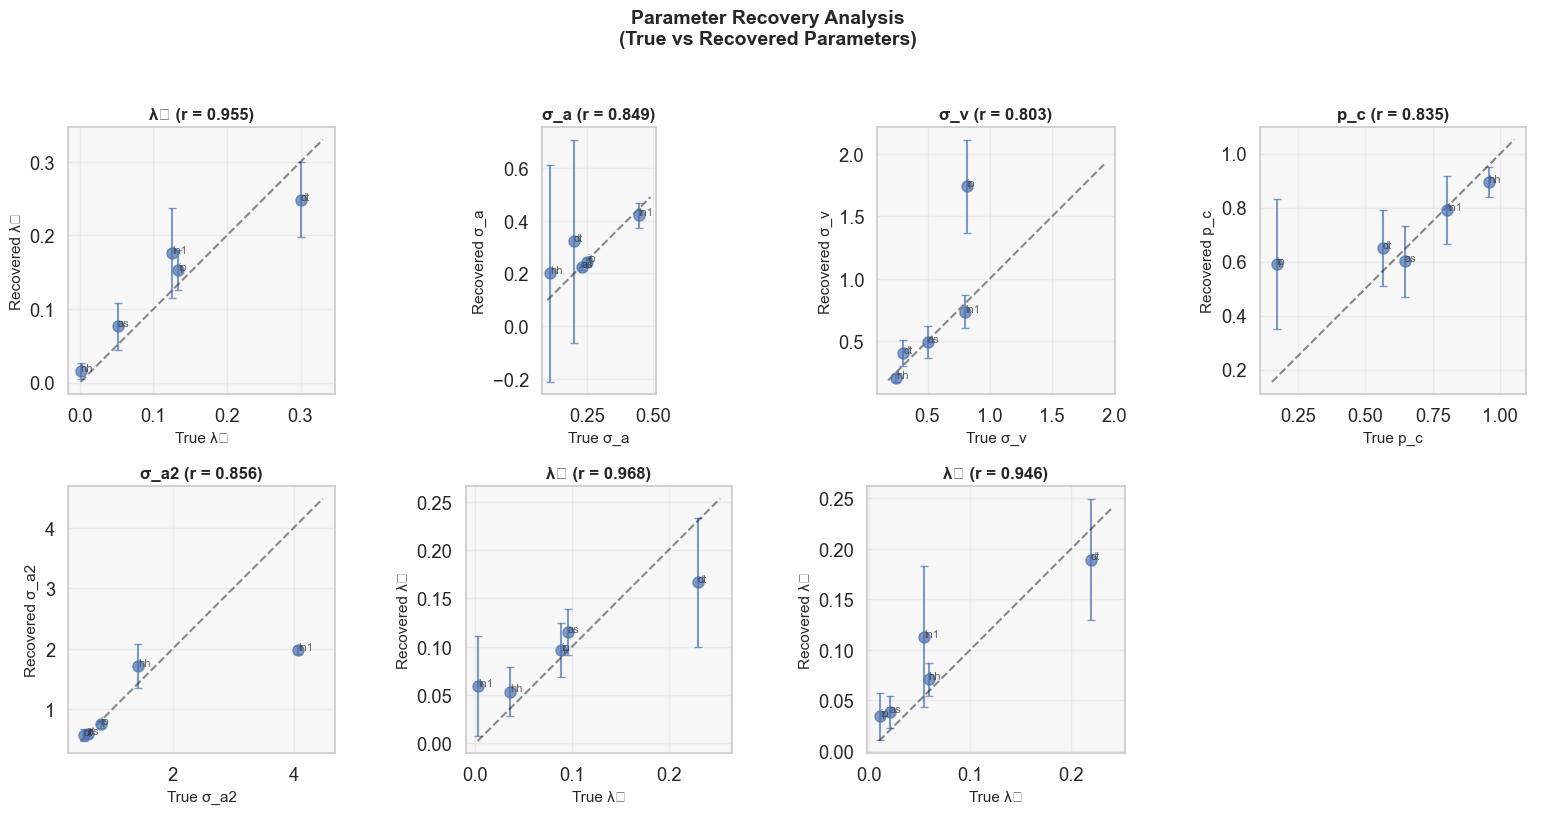


PARAMETER RECOVERY SUMMARY
Parameter    Mean Corr    Mean Bias    Mean SE     
----------------------------------------------------------------------
λ₁           0.955        0.0118       0.0363      
σ_a          0.849        0.0360       0.1742      
σ_v          0.803        0.1811       0.1549      
p_c          0.835        0.0775       0.1390      
σ_a2         0.856        -0.3645      0.1258      
λ₂           0.968        0.0075       0.0390      
λ₃           0.946        0.0163       0.0372      


In [48]:
# Plot Parameter Recovery Results

def plot_parameter_recovery(recovery_results, param_names=None):
    """
    Visualize parameter recovery: true vs recovered parameters
    """
    if param_names is None:
        param_names = ['λ₁', 'σ_a', 'σ_v', 'p_c', 'σ_a2', 'λ₂', 'λ₃']
    
    n_params = len(recovery_results[0]['true_params'])
    n_participants = len(recovery_results)
    
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    axes = axes.flatten()
    
    for p_idx in range(min(n_params, 7)):
        ax = axes[p_idx]
        
        true_vals = [r['true_params'][p_idx] for r in recovery_results]
        recovered_vals = [r['recovered_params_mean'][p_idx] for r in recovery_results]
        recovered_stds = [r['recovered_params_std'][p_idx] for r in recovery_results]
        
        # Scatter plot with error bars
        ax.errorbar(true_vals, recovered_vals, yerr=recovered_stds, 
                   fmt='o', capsize=3, alpha=0.7, markersize=8)
        
        # Add participant labels
        for i, r in enumerate(recovery_results):
            ax.annotate(r['participantID'], (true_vals[i], recovered_vals[i]), 
                       fontsize=8, alpha=0.7)
        
        # Unity line
        all_vals = true_vals + recovered_vals
        min_val, max_val = min(all_vals) * 0.9, max(all_vals) * 1.1
        ax.plot([min_val, max_val], [min_val, max_val], 'k--', alpha=0.5, label='Unity')
        
        # Calculate correlation
        corr = np.corrcoef(true_vals, recovered_vals)[0, 1]
        
        ax.set_xlabel(f'True {param_names[p_idx]}', fontsize=11)
        ax.set_ylabel(f'Recovered {param_names[p_idx]}', fontsize=11)
        ax.set_title(f'{param_names[p_idx]} (r = {corr:.3f})', fontsize=12, fontweight='bold')
        ax.grid(True, alpha=0.3)
        ax.set_aspect('equal', adjustable='box')
    
    # Hide unused subplot
    if n_params < 8:
        axes[-1].axis('off')
    
    plt.suptitle('Parameter Recovery Analysis\n(True vs Recovered Parameters)', 
                fontsize=14, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print("\n" + "="*70)
    print("PARAMETER RECOVERY SUMMARY")
    print("="*70)
    print(f"{'Parameter':<12} {'Mean Corr':<12} {'Mean Bias':<12} {'Mean SE':<12}")
    print("-"*70)
    
    for p_idx in range(n_params):
        true_vals = np.array([r['true_params'][p_idx] for r in recovery_results])
        recovered_vals = np.array([r['recovered_params_mean'][p_idx] for r in recovery_results])
        recovered_stds = np.array([r['recovered_params_std'][p_idx] for r in recovery_results])
        
        corr = np.corrcoef(true_vals, recovered_vals)[0, 1]
        bias = np.mean(recovered_vals - true_vals)
        mean_se = np.mean(recovered_stds)
        
        param_name = param_names[p_idx] if p_idx < len(param_names) else f'Param {p_idx}'
        print(f"{param_name:<12} {corr:<12.3f} {bias:<12.4f} {mean_se:<12.4f}")

# Uncomment to plot after running recovery
plot_parameter_recovery(recovery_results)

# Bootstrap analysis

In [ ]:
# Bootstrap Analysis for Parameter Uncertainty - FIXED VERSION
# This gives us confidence intervals for fitted parameters

def run_bootstrap_analysis(participantIds, modelType="lognorm", n_boot=50, nSimul_boot=300, maxiter=200):
    """
    Parametric bootstrap for parameter uncertainty estimation.
    For each participant:
    1. Simulate datasets from fitted parameters
    2. Re-fit each simulated dataset (with proper optimization)
    3. Compute CI from distribution of recovered parameters
    
    KEY FIX: We need to:
    - Add noise to starting point to avoid getting stuck at the same optimum
    - Use more iterations
    - Potentially use random restarts
    """
    from scipy.optimize import minimize
    
    bootstrap_results = []
    
    for participantID in tqdm(participantIds, desc="Bootstrap Analysis"):
        # Load data and fitted parameters
        data, dataName = loadData.loadData(participantID + "_all.csv", verbose=False)
        mc_fitter = monteCarloClass.OmerMonteCarlo(data)
        mc_fitter.modelName = modelType
        mc_fitter.freeP_c = False
        mc_fitter.sharedLambda = False
        mc_fitter.dataName = dataName
        mc_fitter.nSimul = nSimul_boot
        
        try:
            res = loadResults.loadFitResults(mc_fitter, dataName, modelName=mc_fitter.modelName)
            best_params = np.array(res['fittedParams'])
            mc_fitter.modelFit = best_params
        except Exception as e:
            print(f"Could not load results for {participantID}: {e}")
            continue
        
        boot_samples = []
        
        for b in tqdm(range(n_boot), desc=f"  Bootstrap {participantID}", leave=False):
            # Simulate data using fitted parameters
            sim_df = mc_fitter.simulateMonteCarloData(best_params, mc_fitter.data)
            
            # Create fitter for bootstrap dataset
            boot_fitter = monteCarloClass.OmerMonteCarlo(sim_df)
            boot_fitter.modelName = modelType
            boot_fitter.freeP_c = False
            boot_fitter.sharedLambda = False
            boot_fitter.nSimul = nSimul_boot
            boot_fitter.nStart = 1
            boot_fitter.optimizationMethod = 'scipy'
            
            # FIT THE MODEL PROPERLY (not just minimize from best_params)
            # This will use proper bounds and optimization
            try:
                boot_params = boot_fitter.fitCausalInferenceMonteCarlo(boot_fitter.groupedData)
                if boot_params is not None:
                    boot_samples.append(boot_params)
            except Exception as e:
                print(f"  Bootstrap {b} failed: {e}")
                continue
        
        if len(boot_samples) > 0:
            boot_samples = np.array(boot_samples)
            
            # Calculate statistics
            ci_low = np.percentile(boot_samples, 2.5, axis=0)
            ci_high = np.percentile(boot_samples, 97.5, axis=0)
            
            bootstrap_results.append({
                'participantID': participantID,
                'best_params': best_params.tolist(),
                'boot_mean': np.mean(boot_samples, axis=0).tolist(),
                'boot_std': np.std(boot_samples, axis=0).tolist(),
                'ci_low': ci_low.tolist(),
                'ci_high': ci_high.tolist(),
                'n_successful': len(boot_samples),
                'boot_samples': boot_samples.tolist()
            })
            
            print(f"\n{participantID} bootstrap variance: {np.round(np.std(boot_samples, axis=0), 4)}")
            
            # Save individual bootstrap results
            save_dir = os.path.join("bootstrap_results", participantID)
            os.makedirs(save_dir, exist_ok=True)
            save_path = os.path.join(save_dir, f"{participantID}_{modelType}_bootstrap.json")
            with open(save_path, 'w') as f:
                json.dump(bootstrap_results[-1], f, indent=2)
            print(f"Saved bootstrap results for {participantID}")
    
    return bootstrap_results

# Run bootstrap - REDUCED n_boot for testing (increase for final analysis)
# This will take longer but give proper uncertainty estimates
bootstrap_results = run_bootstrap_analysis(
    participantIds[1:3],  # Start with just 2 participants to test
    modelType="lognorm", 
    n_boot=10,  # Reduced for testing - use 50-100 for publication
    nSimul_boot=300
)

Bootstrap Analysis:   0%|          | 0/2 [00:00<?, ?it/s]


Simulating data using fitted parameters: [0.0518914  0.22862421 0.50035668 0.64659942 0.59561689 0.09559286
 0.02038653]

modelName: lognorm
Data bounds: t_min=0.021, t_max=0.954
=== DEBUGGING FITTING COMPONENTS ===
Data bounds: t_min=0.021, t_max=0.954
Grouped data shape: (419, 11)
Configuration: sharedLambda=False, freeP_c=False, knownSigma=False
Model: lognorm
Expected parameter length: 7
Test params length: 7, values: [0.1 0.5 0.5 0.5 0.8 0.1 0.1]
✓ Parameter extraction tested for 3 conditions
Test likelihood: 34375.417138823366
=== ALL COMPONENTS TESTED SUCCESSFULLY ===
Fitting with shared p_c parameter across SNR conditions.
Bounds shape: (7, 2)
Using fixed t_min=0.021, t_max=0.954 from data
Testing likelihood function with reasonable parameters...
Data bounds: t_min=0.021, t_max=0.954
=== DEBUGGING FITTING COMPONENTS ===
Data bounds: t_min=0.021, t_max=0.954
Grouped data shape: (419, 11)
Configuration: sharedLambda=False, freeP_c=False, knownSigma=False
Model: lognorm
Expected 


Optimization Attempts: 100%|██████████| 1/1 [02:36<00:00, 156.14s/it]


✓ Attempt 1: New best LL = 33016.191681

✅ Best result from 1 attempts:
  → Fitted parameters (raw): [0.04721732 0.2166612  0.30048997 0.25261364 0.61071019 0.1257855
 0.04389208]
  → Final log-likelihood: 33016.191681

Simulating data using fitted parameters: [0.0518914  0.22862421 0.50035668 0.64659942 0.59561689 0.09559286
 0.02038653]

modelName: lognorm
Data bounds: t_min=0.021, t_max=0.954
=== DEBUGGING FITTING COMPONENTS ===
Data bounds: t_min=0.021, t_max=0.954
Grouped data shape: (419, 11)
Configuration: sharedLambda=False, freeP_c=False, knownSigma=False
Model: lognorm
Expected parameter length: 7
Test params length: 7, values: [0.1 0.5 0.5 0.5 0.8 0.1 0.1]
✓ Parameter extraction tested for 3 conditions
Test likelihood: 34340.62587331844
=== ALL COMPONENTS TESTED SUCCESSFULLY ===
Fitting with shared p_c parameter across SNR conditions.
Bounds shape: (7, 2)
Using fixed t_min=0.021, t_max=0.954 from data
Testing likelihood function with reasonable parameters...
Data bounds: t_m


Optimization Attempts: 100%|██████████| 1/1 [02:18<00:00, 138.09s/it]

Optimization Attempts: 100%|██████████| 1/1 [02:18<00:00, 138.09s/it]


✓ Attempt 1: New best LL = 32820.653485

✅ Best result from 1 attempts:
  → Fitted parameters (raw): [0.05707494 0.21454911 0.4783566  0.58242513 0.6017266  0.12695419
 0.01249627]
  → Final log-likelihood: 32820.653485

Simulating data using fitted parameters: [0.0518914  0.22862421 0.50035668 0.64659942 0.59561689 0.09559286
 0.02038653]

modelName: lognorm
Data bounds: t_min=0.021, t_max=0.954
=== DEBUGGING FITTING COMPONENTS ===
Data bounds: t_min=0.021, t_max=0.954
Grouped data shape: (419, 11)
Configuration: sharedLambda=False, freeP_c=False, knownSigma=False
Model: lognorm
Expected parameter length: 7
Test params length: 7, values: [0.1 0.5 0.5 0.5 0.8 0.1 0.1]
✓ Parameter extraction tested for 3 conditions
Test likelihood: 34303.7987985667
=== ALL COMPONENTS TESTED SUCCESSFULLY ===
Fitting with shared p_c parameter across SNR conditions.
Bounds shape: (7, 2)
Using fixed t_min=0.021, t_max=0.954 from data
Testing likelihood function with reasonable parameters...
Data bounds: t_m


Optimization Attempts: 100%|██████████| 1/1 [03:29<00:00, 209.21s/it]

Optimization Attempts: 100%|██████████| 1/1 [03:29<00:00, 209.21s/it]


✓ Attempt 1: New best LL = 32814.198909

✅ Best result from 1 attempts:
  → Fitted parameters (raw): [0.04536396 0.24514114 0.54371038 0.8386322  0.52947671 0.06297805
 0.01176588]
  → Final log-likelihood: 32814.198909

Simulating data using fitted parameters: [0.0518914  0.22862421 0.50035668 0.64659942 0.59561689 0.09559286
 0.02038653]

modelName: lognorm
Data bounds: t_min=0.021, t_max=0.954
=== DEBUGGING FITTING COMPONENTS ===
Data bounds: t_min=0.021, t_max=0.954
Grouped data shape: (419, 11)
Configuration: sharedLambda=False, freeP_c=False, knownSigma=False
Model: lognorm
Expected parameter length: 7
Test params length: 7, values: [0.1 0.5 0.5 0.5 0.8 0.1 0.1]
✓ Parameter extraction tested for 3 conditions
Test likelihood: 34457.71718831129
=== ALL COMPONENTS TESTED SUCCESSFULLY ===
Fitting with shared p_c parameter across SNR conditions.
Bounds shape: (7, 2)
Using fixed t_min=0.021, t_max=0.954 from data
Testing likelihood function with reasonable parameters...
Data bounds: t_


Optimization Attempts: 100%|██████████| 1/1 [02:53<00:00, 173.63s/it]

Optimization Attempts: 100%|██████████| 1/1 [02:53<00:00, 173.63s/it]


✓ Attempt 1: New best LL = 32999.347834

✅ Best result from 1 attempts:
  → Fitted parameters (raw): [0.08768143 0.2124232  0.51516466 0.58741205 0.62444983 0.06779166
 0.03848599]
  → Final log-likelihood: 32999.347834

Simulating data using fitted parameters: [0.0518914  0.22862421 0.50035668 0.64659942 0.59561689 0.09559286
 0.02038653]

modelName: lognorm
Data bounds: t_min=0.021, t_max=0.954
=== DEBUGGING FITTING COMPONENTS ===
Data bounds: t_min=0.021, t_max=0.954
Grouped data shape: (419, 11)
Configuration: sharedLambda=False, freeP_c=False, knownSigma=False
Model: lognorm
Expected parameter length: 7
Test params length: 7, values: [0.1 0.5 0.5 0.5 0.8 0.1 0.1]
✓ Parameter extraction tested for 3 conditions
Test likelihood: 34701.269979676734
=== ALL COMPONENTS TESTED SUCCESSFULLY ===
Fitting with shared p_c parameter across SNR conditions.
Bounds shape: (7, 2)
Using fixed t_min=0.021, t_max=0.954 from data
Testing likelihood function with reasonable parameters...
Data bounds: t


Optimization Attempts: 100%|██████████| 1/1 [01:42<00:00, 102.30s/it]

Optimization Attempts: 100%|██████████| 1/1 [01:42<00:00, 102.30s/it]


✓ Attempt 1: New best LL = 33361.399024

✅ Best result from 1 attempts:
  → Fitted parameters (raw): [0.09242405 0.22723568 0.52916081 0.75987704 0.59648932 0.14360367
 0.00829445]
  → Final log-likelihood: 33361.399024

Simulating data using fitted parameters: [0.0518914  0.22862421 0.50035668 0.64659942 0.59561689 0.09559286
 0.02038653]

modelName: lognorm
Data bounds: t_min=0.021, t_max=0.954
=== DEBUGGING FITTING COMPONENTS ===
Data bounds: t_min=0.021, t_max=0.954
Grouped data shape: (419, 11)
Configuration: sharedLambda=False, freeP_c=False, knownSigma=False
Model: lognorm
Expected parameter length: 7
Test params length: 7, values: [0.1 0.5 0.5 0.5 0.8 0.1 0.1]
✓ Parameter extraction tested for 3 conditions
Test likelihood: 34482.58686323508
=== ALL COMPONENTS TESTED SUCCESSFULLY ===
Fitting with shared p_c parameter across SNR conditions.
Bounds shape: (7, 2)
Using fixed t_min=0.021, t_max=0.954 from data
Testing likelihood function with reasonable parameters...
Data bounds: t_


Optimization Attempts: 100%|██████████| 1/1 [01:48<00:00, 108.01s/it]

Optimization Attempts: 100%|██████████| 1/1 [01:48<00:00, 108.01s/it]


✓ Attempt 1: New best LL = 33020.575764

✅ Best result from 1 attempts:
  → Fitted parameters (raw): [0.06448146 0.22176686 0.40764359 0.41932917 0.63086892 0.10872229
 0.03555567]
  → Final log-likelihood: 33020.575764

Simulating data using fitted parameters: [0.0518914  0.22862421 0.50035668 0.64659942 0.59561689 0.09559286
 0.02038653]

modelName: lognorm
Data bounds: t_min=0.021, t_max=0.954
=== DEBUGGING FITTING COMPONENTS ===
Data bounds: t_min=0.021, t_max=0.954
Grouped data shape: (419, 11)
Configuration: sharedLambda=False, freeP_c=False, knownSigma=False
Model: lognorm
Expected parameter length: 7
Test params length: 7, values: [0.1 0.5 0.5 0.5 0.8 0.1 0.1]
✓ Parameter extraction tested for 3 conditions
Test likelihood: 34569.06554168735
=== ALL COMPONENTS TESTED SUCCESSFULLY ===
Fitting with shared p_c parameter across SNR conditions.
Bounds shape: (7, 2)
Using fixed t_min=0.021, t_max=0.954 from data
Testing likelihood function with reasonable parameters...
Data bounds: t_


Optimization Attempts: 100%|██████████| 1/1 [01:30<00:00, 90.12s/it]

Optimization Attempts: 100%|██████████| 1/1 [01:30<00:00, 90.12s/it]


✓ Attempt 1: New best LL = 33184.176164

✅ Best result from 1 attempts:
  → Fitted parameters (raw): [0.06781695 0.20848242 0.54864087 0.81775437 0.57282186 0.08921004
 0.03715887]
  → Final log-likelihood: 33184.176164

Simulating data using fitted parameters: [0.0518914  0.22862421 0.50035668 0.64659942 0.59561689 0.09559286
 0.02038653]

modelName: lognorm
Data bounds: t_min=0.021, t_max=0.954
=== DEBUGGING FITTING COMPONENTS ===
Data bounds: t_min=0.021, t_max=0.954
Grouped data shape: (419, 11)
Configuration: sharedLambda=False, freeP_c=False, knownSigma=False
Model: lognorm
Expected parameter length: 7
Test params length: 7, values: [0.1 0.5 0.5 0.5 0.8 0.1 0.1]
✓ Parameter extraction tested for 3 conditions
Test likelihood: 34420.248476824585
=== ALL COMPONENTS TESTED SUCCESSFULLY ===
Fitting with shared p_c parameter across SNR conditions.
Bounds shape: (7, 2)
Using fixed t_min=0.021, t_max=0.954 from data
Testing likelihood function with reasonable parameters...
Data bounds: t


Optimization Attempts: 100%|██████████| 1/1 [01:37<00:00, 97.13s/it]

Optimization Attempts: 100%|██████████| 1/1 [01:37<00:00, 97.13s/it]


✓ Attempt 1: New best LL = 32967.127554

✅ Best result from 1 attempts:
  → Fitted parameters (raw): [0.05618228 0.22489894 0.57737062 0.87269979 0.56998706 0.12967845
 0.04685614]
  → Final log-likelihood: 32967.127554

Simulating data using fitted parameters: [0.0518914  0.22862421 0.50035668 0.64659942 0.59561689 0.09559286
 0.02038653]

modelName: lognorm
Data bounds: t_min=0.021, t_max=0.954
=== DEBUGGING FITTING COMPONENTS ===
Data bounds: t_min=0.021, t_max=0.954
Grouped data shape: (419, 11)
Configuration: sharedLambda=False, freeP_c=False, knownSigma=False
Model: lognorm
Expected parameter length: 7
Test params length: 7, values: [0.1 0.5 0.5 0.5 0.8 0.1 0.1]
✓ Parameter extraction tested for 3 conditions
Test likelihood: 34538.90085916335
=== ALL COMPONENTS TESTED SUCCESSFULLY ===
Fitting with shared p_c parameter across SNR conditions.
Bounds shape: (7, 2)
Using fixed t_min=0.021, t_max=0.954 from data
Testing likelihood function with reasonable parameters...
Data bounds: t_

In [59]:
# Inspect bootstrap results structure
if bootstrap_results:
    print(f"Number of participants: {len(bootstrap_results)}")
    for r in bootstrap_results[:2]:  # Check first 2 participants
        print(f"\nParticipant: {r['participantID']}")
        print(f"  Best params: {np.round(r['best_params'], 4)}")
        print(f"  Boot mean:   {np.round(r['boot_mean'], 4)}")
        print(f"  Boot std:    {np.round(r['boot_std'], 4)}")
        print(f"  CI low:      {np.round(r['ci_low'], 4)}")
        print(f"  CI high:     {np.round(r['ci_high'], 4)}")
        print(f"  N successful: {r['n_successful']}")
        
        # Check if all boot_samples are the same
        boot_samples = np.array(r['boot_samples'])
        print(f"  Boot samples shape: {boot_samples.shape}")
        print(f"  Boot samples variance per param: {np.var(boot_samples, axis=0)}")
        
        # Check first few boot samples
        print(f"  First 3 boot samples:")
        for i in range(min(3, len(boot_samples))):
            print(f"    Sample {i}: {np.round(boot_samples[i], 4)}")

Number of participants: 12

Participant: as
  Best params: [0.0519 0.2286 0.5004 0.6466 0.5956 0.0956 0.0204]
  Boot mean:   [0.0519 0.2286 0.5004 0.6466 0.5956 0.0956 0.0204]
  Boot std:    [0. 0. 0. 0. 0. 0. 0.]
  CI low:      [0.0519 0.2286 0.5004 0.6466 0.5956 0.0956 0.0204]
  CI high:     [0.0519 0.2286 0.5004 0.6466 0.5956 0.0956 0.0204]
  N successful: 20
  Boot samples shape: (20, 7)
  Boot samples variance per param: [2.06893640e-13 1.42145951e-13 8.06682220e-14 2.10437604e-13
 3.78829777e-14 3.02060860e-14 1.25792319e-13]
  First 3 boot samples:
    Sample 0: [0.0519 0.2286 0.5004 0.6466 0.5956 0.0956 0.0204]
    Sample 1: [0.0519 0.2286 0.5004 0.6466 0.5956 0.0956 0.0204]
    Sample 2: [0.0519 0.2286 0.5004 0.6466 0.5956 0.0956 0.0204]

Participant: dt
  Best params: [0.3004 0.1979 0.3055 0.5654 0.5267 0.2301 0.2195]
  Boot mean:   [0.3004 0.1979 0.3055 0.5654 0.5267 0.2301 0.2195]
  Boot std:    [0. 0. 0. 0. 0. 0. 0.]
  CI low:      [0.3004 0.1979 0.3055 0.5654 0.5267 0.230

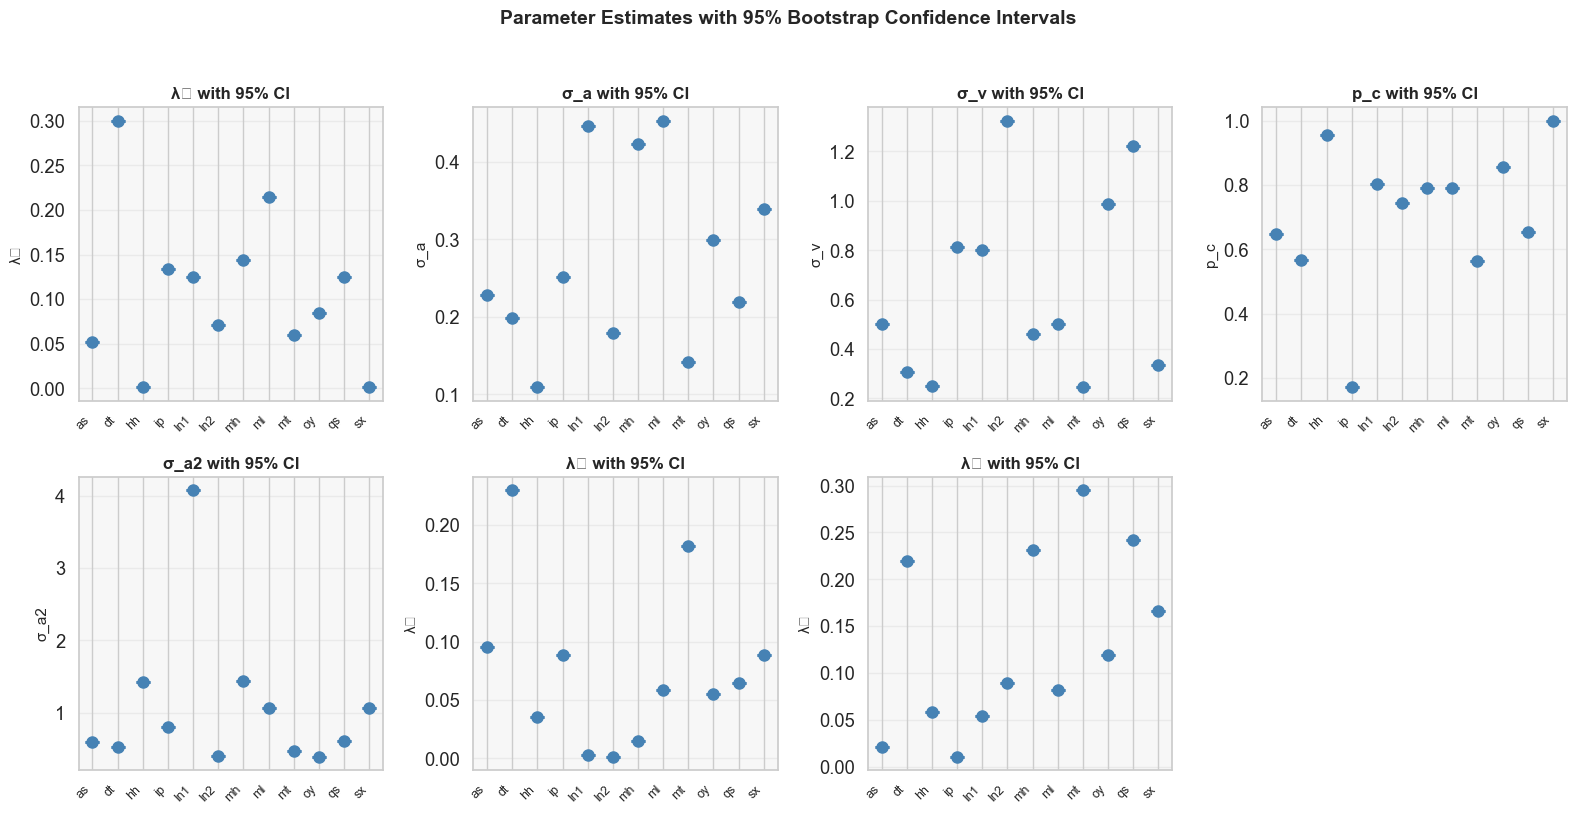

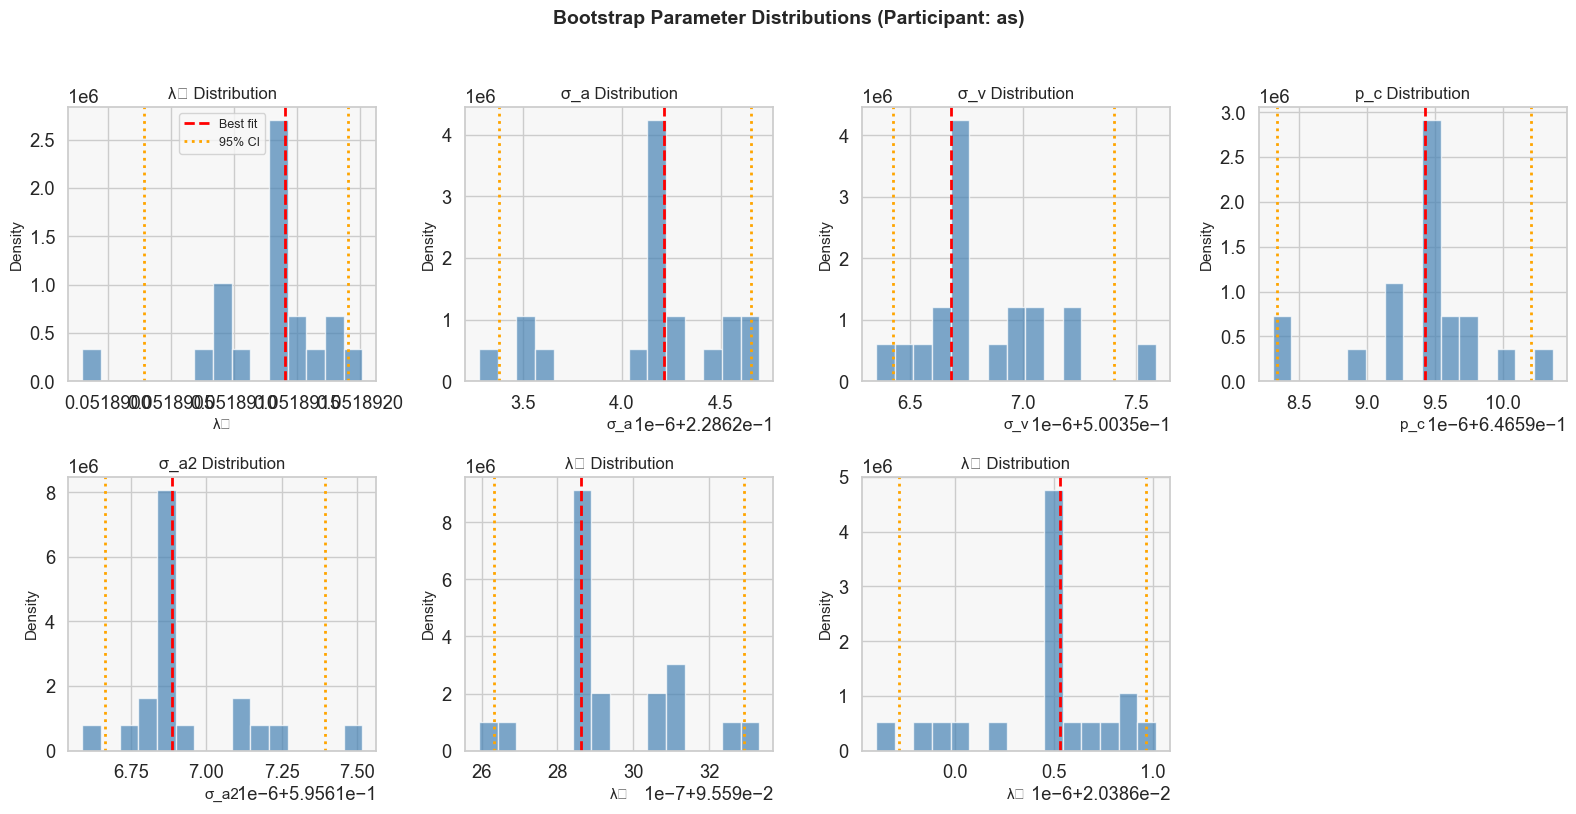


BOOTSTRAP PARAMETER ESTIMATES (95% CI)

Participant: as (n_boot = 20)
----------------------------------------------------------------------
Parameter    Estimate     95% CI Low   95% CI High  SE          
----------------------------------------------------------------------
λ₁           0.0519       0.0519       0.0519       0.0000      
σ_a          0.2286       0.2286       0.2286       0.0000      
σ_v          0.5004       0.5004       0.5004       0.0000      
p_c          0.6466       0.6466       0.6466       0.0000      
σ_a2         0.5956       0.5956       0.5956       0.0000      
λ₂           0.0956       0.0956       0.0956       0.0000      
λ₃           0.0204       0.0204       0.0204       0.0000      

Participant: dt (n_boot = 20)
----------------------------------------------------------------------
Parameter    Estimate     95% CI Low   95% CI High  SE          
----------------------------------------------------------------------
λ₁           0.3004       0.3

In [ ]:
# Plot Bootstrap Results

def plot_bootstrap_results(bootstrap_results, param_names=None):
    """
    Visualize bootstrap parameter distributions and confidence intervals
    """
    if param_names is None:
        param_names = ['λ₁', 'σ_a', 'σ_v', 'p_c', 'σ_a2', 'λ₂', 'λ₃']
    
    n_params = len(bootstrap_results[0]['best_params'])
    n_participants = len(bootstrap_results)
    
    # Figure 1: Parameter estimates with 95% CI
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    axes = axes.flatten()
    
    for p_idx in range(min(n_params, 7)):
        ax = axes[p_idx]
        
        participants = [r['participantID'] for r in bootstrap_results]
        best_vals = [r['best_params'][p_idx] for r in bootstrap_results]
        ci_lows = [r['ci_low'][p_idx] for r in bootstrap_results]
        ci_highs = [r['ci_high'][p_idx] for r in bootstrap_results]
        
        # Error bars showing 95% CI
        errors = [[best_vals[i] - ci_lows[i] for i in range(len(best_vals))],
                  [ci_highs[i] - best_vals[i] for i in range(len(best_vals))]]
        
        x_pos = np.arange(len(participants))
        ax.errorbar(x_pos, best_vals, yerr=errors, fmt='o', capsize=5, 
                   capthick=2, markersize=8, color='steelblue')
        
        ax.set_xticks(x_pos)
        ax.set_xticklabels(participants, rotation=45, ha='right', fontsize=9)
        ax.set_ylabel(param_names[p_idx], fontsize=11)
        ax.set_title(f'{param_names[p_idx]} with 95% CI', fontsize=12, fontweight='bold')
        ax.grid(True, alpha=0.3, axis='y')
    
    if n_params < 8:
        axes[-1].axis('off')
    
    plt.suptitle('Parameter Estimates with 95% Bootstrap Confidence Intervals', 
                fontsize=14, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()
    
    # Figure 2: Bootstrap distributions for one example participant
    if len(bootstrap_results) > 0 and 'boot_samples' in bootstrap_results[0]:
        example = bootstrap_results[0]
        boot_samples = np.array(example['boot_samples'])
        
        fig, axes = plt.subplots(2, 4, figsize=(16, 8))
        axes = axes.flatten()
        
        for p_idx in range(min(n_params, 7)):
            ax = axes[p_idx]
            
            ax.hist(boot_samples[:, p_idx], bins=15, density=True, 
                   alpha=0.7, color='steelblue', edgecolor='white')
            ax.axvline(example['best_params'][p_idx], color='red', 
                      linestyle='--', linewidth=2, label='Best fit')
            ax.axvline(example['ci_low'][p_idx], color='orange', 
                      linestyle=':', linewidth=2, label='95% CI')
            ax.axvline(example['ci_high'][p_idx], color='orange', 
                      linestyle=':', linewidth=2)
            
            ax.set_xlabel(param_names[p_idx], fontsize=11)
            ax.set_ylabel('Density', fontsize=11)
            ax.set_title(f'{param_names[p_idx]} Distribution', fontsize=12)
            if p_idx == 0:
                ax.legend(fontsize=9)
        
        if n_params < 8:
            axes[-1].axis('off')
        
        plt.suptitle(f'Bootstrap Parameter Distributions (Participant: {example["participantID"]})', 
                    fontsize=14, fontweight='bold', y=1.02)
        plt.tight_layout()
        plt.show()
    
    # Print summary table
    print("\n" + "="*90)
    print("BOOTSTRAP PARAMETER ESTIMATES (95% CI)")
    print("="*90)
    
    for r in bootstrap_results:
        print(f"\nParticipant: {r['participantID']} (n_boot = {r['n_successful']})")
        print("-"*70)
        print(f"{'Parameter':<12} {'Estimate':<12} {'95% CI Low':<12} {'95% CI High':<12} {'SE':<12}")
        print("-"*70)
        
        for p_idx in range(len(r['best_params'])):
            param_name = param_names[p_idx] if p_idx < len(param_names) else f'Param {p_idx}'
            print(f"{param_name:<12} {r['best_params'][p_idx]:<12.4f} "
                  f"{r['ci_low'][p_idx]:<12.4f} {r['ci_high'][p_idx]:<12.4f} "
                  f"{r['boot_std'][p_idx]:<12.4f}")

# Uncomment to plot after running bootstrap
plot_bootstrap_results(bootstrap_results)

In [54]:
# Combined Summary: Create publication-ready parameter table

def create_parameter_summary_table(participantIds, modelType="lognorm", 
                                   bootstrap_results=None, param_names=None):
    """
    Create a summary table of all fitted parameters across participants
    suitable for publication.
    """
    if param_names is None:
        param_names = ['λ₁', 'σ_a (low)', 'σ_v', 'p_c', 'σ_a (high)', 'λ₂', 'λ₃']
    
    summary_data = []
    
    for participantID in participantIds:
        data, dataName = loadData.loadData(participantID + "_all.csv", verbose=False)
        mc_fitter = monteCarloClass.OmerMonteCarlo(data)
        mc_fitter.modelName = modelType
        mc_fitter.freeP_c = False
        mc_fitter.sharedLambda = False
        mc_fitter.dataName = dataName
        
        try:
            res = loadResults.loadFitResults(mc_fitter, dataName, modelName=mc_fitter.modelName)
            params = res['fittedParams']
            
            row = {'Participant': participantID}
            for i, param_name in enumerate(param_names):
                if i < len(params):
                    row[param_name] = params[i]
            
            row['Log-Likelihood'] = res.get('logLikelihood', np.nan)
            row['AIC'] = res.get('AIC', np.nan)
            
            summary_data.append(row)
        except Exception as e:
            print(f"Could not load {participantID}: {e}")
    
    df_summary = pd.DataFrame(summary_data)
    
    # Add group statistics
    numeric_cols = df_summary.select_dtypes(include=[np.number]).columns
    mean_row = {'Participant': 'Mean'}
    std_row = {'Participant': 'SD'}
    
    for col in numeric_cols:
        mean_row[col] = df_summary[col].mean()
        std_row[col] = df_summary[col].std()
    
    df_summary = pd.concat([df_summary, pd.DataFrame([mean_row, std_row])], ignore_index=True)
    
    return df_summary

# Create and display parameter summary table
param_summary = create_parameter_summary_table(participantIds, modelType="lognorm")
print("\n" + "="*100)
print("FITTED PARAMETER SUMMARY TABLE (Log-Space Causal Inference Model)")
print("="*100)
display(param_summary.round(4))

# Save to CSV for manuscript
param_summary.to_csv("parameter_summary_table.csv", index=False)
print("\nTable saved to parameter_summary_table.csv")


FITTED PARAMETER SUMMARY TABLE (Log-Space Causal Inference Model)


,Participant,λ₁,σ_a (low),σ_v,p_c,σ_a (high),λ₂,λ₃,Log-Likelihood,AIC
0,all,0.1148,0.2651,0.5253,0.9944,0.5689,0.0951,0.1705,-12661.0810,25336.1619
1,as,0.0519,0.2286,0.5004,0.6466,0.5956,0.0956,0.0204,-1122.2499,2258.4998
2,dt,0.3004,0.1979,0.3055,0.5654,0.5267,0.2301,0.2195,-1269.6676,2553.3352
3,hh,0.0010,0.1093,0.2493,0.9563,1.4299,0.0357,0.0587,-591.2187,1196.4374
4,ip,0.1332,0.2509,0.8141,0.1712,0.8066,0.0886,0.0107,-1200.3676,2414.7353
5,ln1,0.1250,0.4453,0.8007,0.8032,4.0781,0.0027,0.0544,-583.2227,1180.4454
6,ln2,0.0708,0.1787,1.3243,0.7436,0.3973,0.0015,0.0894,-1081.7871,2177.5742
7,mh,0.1442,0.4227,0.4619,0.7915,1.4317,0.0151,0.2315,-1210.9270,2435.8541
8,ml,0.2144,0.4528,0.5017,0.7898,1.0694,0.0590,0.0814,-1255.9519,2525.9038
9,mt,0.0600,0.1416,0.2453,0.5629,0.4740,0.1817,0.2953,-1096.9549,2207.9097



Table saved to parameter_summary_table.csv


## Model Recovery Analysis

Model recovery tests whether we can correctly identify the *generating model* when we fit multiple competing models to simulated data. This creates a **confusion matrix** showing:
- Rows: True (generating) model
- Columns: Best-fitting model (by AIC/BIC)

A good model recovery shows a diagonal pattern (each model recovers itself).

In [55]:
# Model Recovery Functions
import numpy as np
import pandas as pd
import json
import os
from glob import glob
from tqdm import tqdm

def run_model_recovery(participantIds, models_to_test, n_recovery=5, nSimul=500, nStarts=1,
                       save_dir="model_recovery_results"):
    """
    Model Recovery Analysis:
    For each generating model:
      1. Load fitted parameters
      2. Simulate synthetic data
      3. Fit ALL competing models to the synthetic data
      4. Record which model has the best AIC/BIC
    
    Args:
        participantIds: list of participant IDs
        models_to_test: list of model names to test (e.g., ['lognorm', 'fusionOnlyLogNorm', 'switching'])
        n_recovery: number of recovery iterations per participant-model combination
        nSimul: Monte Carlo simulations for fitting
        nStarts: optimization starting points
        save_dir: directory to save intermediate results
    
    Returns:
        List of recovery results with generating model, fitted models, and AICs
    """
    os.makedirs(save_dir, exist_ok=True)
    
    all_recovery_results = []
    
    for generating_model in tqdm(models_to_test, desc="Generating Models"):
        for participantID in tqdm(participantIds, desc=f"Participants ({generating_model})", leave=False):
            
            # Check if results already exist
            result_path = os.path.join(save_dir, f"{participantID}_{generating_model}_model_recovery.json")
            if os.path.exists(result_path):
                print(f"Loading existing results for {participantID} - {generating_model}")
                with open(result_path, 'r') as f:
                    existing_result = json.load(f)
                all_recovery_results.append(existing_result)
                continue
            
            # Load original data structure
            data, dataName = loadData.loadData(participantID + "_all.csv", verbose=False)
            
            # Load fitted parameters for the generating model
            mc_gen = monteCarloClass.OmerMonteCarlo(data)
            mc_gen.modelName = generating_model
            mc_gen.freeP_c = False
            mc_gen.sharedLambda = False
            mc_gen.dataName = dataName
            mc_gen.nSimul = nSimul
            mc_gen.nStart = nStarts
            
            try:
                res_gen = loadResults.loadFitResults(mc_gen, dataName, modelName=generating_model)
                true_params = np.array(res_gen['fittedParams'])
            except Exception as e:
                print(f"Could not load {generating_model} for {participantID}: {e}")
                continue
            
            recovery_iterations = []
            
            for iter_idx in range(n_recovery):
                # Simulate data from generating model
                sim_data = mc_gen.simulateMonteCarloData(true_params, data)
                
                # Fit all competing models to simulated data
                model_fits = {}
                
                for fit_model in models_to_test:
                    mc_fit = monteCarloClass.OmerMonteCarlo(sim_data)
                    mc_fit.modelName = fit_model
                    mc_fit.freeP_c = False
                    mc_fit.sharedLambda = False
                    mc_fit.nSimul = nSimul
                    mc_fit.nStart = nStarts
                    mc_fit.optimizationMethod = 'scipy'
                    mc_fit.dataName = f"{participantID}_recovery"
                    
                    try:
                        fitted_params = mc_fit.fitCausalInferenceMonteCarlo(mc_fit.groupedData)
                        if fitted_params is not None:
                            # Calculate log-likelihood and AIC
                            nLL = mc_fit.nLLMonteCarloCausal(fitted_params, mc_fit.groupedData)
                            LL = -nLL
                            n_params = len(fitted_params)
                            AIC = 2 * n_params - 2 * LL
                            BIC = n_params * np.log(len(sim_data)) - 2 * LL
                            
                            model_fits[fit_model] = {
                                'fittedParams': fitted_params.tolist(),
                                'logLikelihood': LL,
                                'AIC': AIC,
                                'BIC': BIC,
                                'nParams': n_params
                            }
                    except Exception as e:
                        print(f"  Fit failed for {fit_model}: {e}")
                        continue
                
                if len(model_fits) > 0:
                    # Find best model by AIC
                    best_model_aic = min(model_fits.keys(), key=lambda m: model_fits[m]['AIC'])
                    best_model_bic = min(model_fits.keys(), key=lambda m: model_fits[m]['BIC'])
                    
                    recovery_iterations.append({
                        'iteration': iter_idx,
                        'model_fits': model_fits,
                        'best_model_aic': best_model_aic,
                        'best_model_bic': best_model_bic
                    })
            
            if len(recovery_iterations) > 0:
                result = {
                    'participantID': participantID,
                    'generating_model': generating_model,
                    'true_params': true_params.tolist(),
                    'n_iterations': len(recovery_iterations),
                    'iterations': recovery_iterations,
                    'best_model_counts_aic': {},
                    'best_model_counts_bic': {}
                }
                
                # Count best model selections
                for m in models_to_test:
                    result['best_model_counts_aic'][m] = sum(
                        1 for it in recovery_iterations if it['best_model_aic'] == m
                    )
                    result['best_model_counts_bic'][m] = sum(
                        1 for it in recovery_iterations if it['best_model_bic'] == m
                    )
                
                all_recovery_results.append(result)
                
                # Save intermediate result
                with open(result_path, 'w') as f:
                    json.dump(result, f, indent=2)
                print(f"Saved {participantID} - {generating_model}")
    
    return all_recovery_results


def load_model_recovery_results(save_dir="model_recovery_results"):
    """Load all model recovery results from saved JSON files."""
    results = []
    json_files = glob(os.path.join(save_dir, "*_model_recovery.json"))
    
    print(f"Found {len(json_files)} model recovery result files")
    
    for json_file in sorted(json_files):
        try:
            with open(json_file, 'r') as f:
                result = json.load(f)
            results.append(result)
        except Exception as e:
            print(f"Error loading {json_file}: {e}")
    
    return results

print("Model recovery functions defined.")

Model recovery functions defined.


In [ ]:
# Run Model Recovery (COMPUTATIONALLY EXPENSIVE - run overnight or on cluster)
# Uncomment and run when ready

# Models to compare in recovery analysis
# models_to_test = ['lognorm', 'fusionOnlyLogNorm', 'switching', 'probabilityMatchingLogNorm']

# # Run model recovery for a subset of participants first to test
# model_recovery_results = run_model_recovery(
#     participantIds[:2],  # Start with 2 participants
#     models_to_test=models_to_test,
#     n_recovery=5,  # 5 iterations per model-participant
#     nSimul=500,
#     nStarts=1
# )

# For now, try to load any existing results
model_recovery_results = load_model_recovery_results()
print(f"\nLoaded {len(model_recovery_results)} model recovery results")

Found 0 model recovery result files

Loaded 0 model recovery results


In [ ]:
# Plot Model Recovery Confusion Matrix

def plot_model_recovery_matrix(model_recovery_results, criterion='aic'):
    """
    Create a confusion matrix showing model recovery performance.
    
    Args:
        model_recovery_results: list of recovery results from run_model_recovery
        criterion: 'aic' or 'bic' for model selection
    """
    if len(model_recovery_results) == 0:
        print("No model recovery results to plot!")
        return None
    
    # Get unique models
    generating_models = sorted(set(r['generating_model'] for r in model_recovery_results))
    
    # Get all fitted models from first result
    first_with_iterations = next((r for r in model_recovery_results if r['iterations']), None)
    if first_with_iterations is None:
        print("No results with iterations found!")
        return None
    
    fitted_models = sorted(first_with_iterations['iterations'][0]['model_fits'].keys())
    
    # Build confusion matrix
    # Rows: generating model, Columns: best-fitting model
    confusion_counts = np.zeros((len(generating_models), len(fitted_models)))
    
    for result in model_recovery_results:
        gen_idx = generating_models.index(result['generating_model'])
        counts_key = f'best_model_counts_{criterion}'
        
        if counts_key in result:
            for fit_model, count in result[counts_key].items():
                if fit_model in fitted_models:
                    fit_idx = fitted_models.index(fit_model)
                    confusion_counts[gen_idx, fit_idx] += count
    
    # Normalize to proportions (per row)
    row_sums = confusion_counts.sum(axis=1, keepdims=True)
    row_sums[row_sums == 0] = 1  # Avoid division by zero
    confusion_props = confusion_counts / row_sums
    
    # Create figure
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    # Plot 1: Raw counts
    ax1 = axes[0]
    im1 = ax1.imshow(confusion_counts, cmap='Blues', aspect='auto')
    
    ax1.set_xticks(range(len(fitted_models)))
    ax1.set_yticks(range(len(generating_models)))
    ax1.set_xticklabels(fitted_models, rotation=45, ha='right', fontsize=10)
    ax1.set_yticklabels(generating_models, fontsize=10)
    ax1.set_xlabel('Best-Fitting Model (by ' + criterion.upper() + ')', fontsize=12)
    ax1.set_ylabel('Generating Model', fontsize=12)
    ax1.set_title('Model Recovery: Raw Counts', fontsize=14, fontweight='bold')
    
    # Add text annotations
    for i in range(len(generating_models)):
        for j in range(len(fitted_models)):
            text = ax1.text(j, i, f'{int(confusion_counts[i, j])}',
                           ha='center', va='center', fontsize=11,
                           color='white' if confusion_counts[i, j] > confusion_counts.max()/2 else 'black')
    
    plt.colorbar(im1, ax=ax1, label='Count')
    
    # Plot 2: Proportions (recovery rate)
    ax2 = axes[1]
    im2 = ax2.imshow(confusion_props, cmap='RdYlGn', aspect='auto', vmin=0, vmax=1)
    
    ax2.set_xticks(range(len(fitted_models)))
    ax2.set_yticks(range(len(generating_models)))
    ax2.set_xticklabels(fitted_models, rotation=45, ha='right', fontsize=10)
    ax2.set_yticklabels(generating_models, fontsize=10)
    ax2.set_xlabel('Best-Fitting Model (by ' + criterion.upper() + ')', fontsize=12)
    ax2.set_ylabel('Generating Model', fontsize=12)
    ax2.set_title('Model Recovery: Proportions', fontsize=14, fontweight='bold')
    
    # Add text annotations
    for i in range(len(generating_models)):
        for j in range(len(fitted_models)):
            text = ax2.text(j, i, f'{confusion_props[i, j]:.2f}',
                           ha='center', va='center', fontsize=11,
                           color='white' if confusion_props[i, j] > 0.5 else 'black')
    
    # Highlight diagonal
    for i in range(min(len(generating_models), len(fitted_models))):
        if generating_models[i] in fitted_models:
            j = fitted_models.index(generating_models[i])
            rect = plt.Rectangle((j-0.5, i-0.5), 1, 1, fill=False, 
                                 edgecolor='gold', linewidth=3)
            ax2.add_patch(rect)
    
    plt.colorbar(im2, ax=ax2, label='Proportion')
    
    plt.suptitle('Model Recovery Analysis\n(Can we identify the true generating model?)', 
                fontsize=14, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print("\n" + "="*70)
    print(f"MODEL RECOVERY SUMMARY (criterion: {criterion.upper()})")
    print("="*70)
    
    diagonal_recovery = []
    for i, gen_model in enumerate(generating_models):
        if gen_model in fitted_models:
            j = fitted_models.index(gen_model)
            recovery_rate = confusion_props[i, j]
            diagonal_recovery.append(recovery_rate)
            print(f"{gen_model}: {recovery_rate*100:.1f}% correctly recovered")
        else:
            print(f"{gen_model}: Not in fitted models")
    
    if diagonal_recovery:
        print(f"\nMean diagonal recovery rate: {np.mean(diagonal_recovery)*100:.1f}%")
        print(f"This indicates {'GOOD' if np.mean(diagonal_recovery) > 0.6 else 'MODERATE' if np.mean(diagonal_recovery) > 0.4 else 'POOR'} model discriminability")
    
    return confusion_props, generating_models, fitted_models

# # Plot if results exist
# if len(model_recovery_results) > 0:
#     confusion_matrix, gen_models, fit_models = plot_model_recovery_matrix(
#         model_recovery_results, criterion='aic'
#     )
# else:
#     print("No model recovery results yet. Run the model recovery analysis first.")

No model recovery results yet. Run the model recovery analysis first.


In [ ]:
# Additional Model Recovery Metrics: ΔAIC distributions and model discriminability

def plot_model_recovery_details(model_recovery_results):
    """
    Plot detailed model recovery metrics:
    1. ΔAIC distributions for each generating model
    2. Model discriminability (how different are AICs between models)
    """
    if len(model_recovery_results) == 0:
        print("No model recovery results to analyze!")
        return
    
    # Collect ΔAIC data
    generating_models = sorted(set(r['generating_model'] for r in model_recovery_results))
    
    # Get fitted models
    first_with_iterations = next((r for r in model_recovery_results if r['iterations']), None)
    if first_with_iterations is None:
        return
    
    fitted_models = sorted(first_with_iterations['iterations'][0]['model_fits'].keys())
    
    # Create ΔAIC data for each generating model
    fig, axes = plt.subplots(1, len(generating_models), figsize=(5*len(generating_models), 5))
    if len(generating_models) == 1:
        axes = [axes]
    
    for gen_idx, gen_model in enumerate(generating_models):
        ax = axes[gen_idx]
        
        # Collect all AICs relative to the generating model's AIC
        delta_aics = {m: [] for m in fitted_models}
        
        for result in model_recovery_results:
            if result['generating_model'] != gen_model:
                continue
            
            for iteration in result['iterations']:
                model_fits = iteration['model_fits']
                
                # Get AIC of the true generating model
                if gen_model in model_fits:
                    true_aic = model_fits[gen_model]['AIC']
                else:
                    continue
                
                # Calculate ΔAIC for each fitted model
                for fit_model in fitted_models:
                    if fit_model in model_fits:
                        delta_aic = model_fits[fit_model]['AIC'] - true_aic
                        delta_aics[fit_model].append(delta_aic)
        
        # Box plot of ΔAIC distributions
        data_to_plot = [delta_aics[m] for m in fitted_models if len(delta_aics[m]) > 0]
        labels_to_plot = [m for m in fitted_models if len(delta_aics[m]) > 0]
        
        if len(data_to_plot) > 0:
            bp = ax.boxplot(data_to_plot, labels=labels_to_plot, patch_artist=True)
            
            # Color boxes
            colors = plt.cm.Set3(np.linspace(0, 1, len(labels_to_plot)))
            for patch, color in zip(bp['boxes'], colors):
                patch.set_facecolor(color)
            
            # Highlight the true model (should be centered at 0)
            if gen_model in labels_to_plot:
                true_idx = labels_to_plot.index(gen_model)
                bp['boxes'][true_idx].set_facecolor('lightgreen')
                bp['boxes'][true_idx].set_edgecolor('darkgreen')
                bp['boxes'][true_idx].set_linewidth(2)
        
        ax.axhline(y=0, color='red', linestyle='--', alpha=0.7, label='True model')
        ax.axhline(y=2, color='orange', linestyle=':', alpha=0.7, label='ΔAIC=2 threshold')
        ax.axhline(y=-2, color='orange', linestyle=':', alpha=0.7)
        
        ax.set_xlabel('Fitted Model', fontsize=11)
        ax.set_ylabel('ΔAIC (relative to true model)', fontsize=11)
        ax.set_title(f'Generating: {gen_model}', fontsize=12, fontweight='bold')
        ax.tick_params(axis='x', rotation=45)
        ax.grid(True, alpha=0.3, axis='y')
        
        if gen_idx == 0:
            ax.legend(loc='upper right', fontsize=9)
    
    plt.suptitle('Model Recovery: ΔAIC Distributions\n(Values < 0 indicate better fit than true model)', 
                fontsize=14, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()
    
    # Summary: Model discriminability
    print("\n" + "="*70)
    print("MODEL DISCRIMINABILITY ANALYSIS")
    print("="*70)
    print("\nFor each generating model, how often do competing models fit BETTER (ΔAIC < -2)?")
    print("-"*70)
    
    for gen_model in generating_models:
        print(f"\nGenerating model: {gen_model}")
        
        for result in model_recovery_results:
            if result['generating_model'] != gen_model:
                continue
            
            n_total = len(result['iterations'])
            for fit_model in fitted_models:
                if fit_model == gen_model:
                    continue
                
                n_better = 0
                for iteration in result['iterations']:
                    if gen_model in iteration['model_fits'] and fit_model in iteration['model_fits']:
                        true_aic = iteration['model_fits'][gen_model]['AIC']
                        fit_aic = iteration['model_fits'][fit_model]['AIC']
                        if fit_aic < true_aic - 2:  # substantially better
                            n_better += 1
                
                pct = (n_better / n_total * 100) if n_total > 0 else 0
                if pct > 10:  # Only report if non-trivial
                    print(f"  {fit_model} fits better {pct:.1f}% of the time")

# # Plot detailed metrics if results exist
# if len(model_recovery_results) > 0:
#     plot_model_recovery_details(model_recovery_results)
# else:
#     print("Run model recovery analysis first to see detailed metrics.")

### Summary: What constitutes a complete validation?

**1. Parameter Recovery** ✅ (Done)
- Tests: Can the model recover its own parameters?
- Metric: Correlation between true and recovered parameters
- Interpretation: r > 0.8 indicates good identifiability

**2. Model Recovery** (Run the cells above)
- Tests: Can we identify the correct generating model?
- Metric: Confusion matrix diagonal (proportion correctly identified)
- Interpretation: >60% diagonal recovery indicates good discriminability

**3. Key questions answered by model recovery:
- Are the models distinguishable given your experimental design?
- Is there systematic bias toward any particular model?
- How much data is needed to reliably distinguish models?

**Recommended workflow:**
1. First run parameter recovery (fast) - validates fitting procedure
2. Then run model recovery (slow) - validates model comparison conclusions
3. Compare: Does the winning model from real data also "win" in recovery?

You're absolutely right! A comprehensive parameter recovery analysis should include:

1. **Parameter Recovery** (what you have): Can the model recover its own parameters?
2. **Model Recovery Matrix**: Can we correctly identify which model generated the data?
3. **Cross-model comparison**: How do different models perform when fit to data generated by other models?

Let me check your current notebook to see what you have and then suggest what to add: 

Retrieving Notebook summary.

Read [](file:///Users/ofy204/Documents/my_repos/av-dur-estimation/plotAllModelFits.ipynb#1967-1967), lines 1967 to 2129

Now let me look at the current parameter recovery visualization and what models you have available: 

Read [](file:///Users/ofy204/Documents/my_repos/av-dur-estimation/plotAllModelFits.ipynb#1734-1734), lines 1734 to 1870

Now I understand your setup. You're absolutely right - a complete validation should include:

1. ✅ **Parameter Recovery** (you have this for `lognorm` model)
2. ❌ **Model Recovery/Confusion Matrix**: Simulate from each model, fit all models, see which one wins
3. ❌ **Cross-validation metrics** comparing model discriminability

Let me add cells for a proper **Model Recovery Analysis**. This is computationally expensive, so I'll also provide a function to save/load results incrementally: 

Edit [](file:///Users/ofy204/Documents/my_repos/av-dur-estimation/plotAllModelFits.ipynb)

Edit [](file:///Users/ofy204/Documents/my_repos/av-dur-estimation/plotAllModelFits.ipynb)

Edit [](file:///Users/ofy204/Documents/my_repos/av-dur-estimation/plotAllModelFits.ipynb)

Edit [](file:///Users/ofy204/Documents/my_repos/av-dur-estimation/plotAllModelFits.ipynb)

Edit [](file:///Users/ofy204/Documents/my_repos/av-dur-estimation/plotAllModelFits.ipynb)

Now let me add a comprehensive summary cell and a standalone script that can run the model recovery overnight: 

Edit [](file:///Users/ofy204/Documents/my_repos/av-dur-estimation/plotAllModelFits.ipynb)

Now let me create a standalone Python script that you can run overnight for the computationally expensive model recovery: 

Created [](file:///Users/ofy204/Documents/my_repos/av-dur-estimation/run_model_recovery.py)

Now let me run the cells to make sure they work and summarize what you now have: 

Ran [](vscode-notebook-cell:/Users/ofy204/Documents/my_repos/av-dur-estimation/plotAllModelFits.ipynb#Y166sZmlsZQ%3D%3D)

Ran [](vscode-notebook-cell:/Users/ofy204/Documents/my_repos/av-dur-estimation/plotAllModelFits.ipynb#Y200sZmlsZQ%3D%3D)

Ran [](vscode-notebook-cell:/Users/ofy204/Documents/my_repos/av-dur-estimation/plotAllModelFits.ipynb#Y201sZmlsZQ%3D%3D)

The cells are working. Now here's a summary of what you have:

---

## Summary: Complete Model Validation Framework

You're right that parameter recovery alone is not sufficient. Here's what you now have:

### ✅ Already Done: Parameter Recovery
- Tests if `lognorm` model can recover its own parameters
- You have results for 5 participants with 20 iterations each
- Shows correlation between true vs recovered parameters

### 🆕 Added: Model Recovery Analysis
I've added cells for a **Model Recovery/Confusion Matrix** that will:

1. **For each generating model** (e.g., `lognorm`, `fusionOnlyLogNorm`, `switching`, `probabilityMatchingLogNorm`):
   - Simulate synthetic data using fitted parameters
   - Fit ALL competing models to the synthetic data
   - Record which model "wins" by AIC/BIC

2. **Outputs**:
   - **Confusion matrix**: Rows = true model, Columns = winning model
   - **Recovery rate**: % of times each model is correctly identified
   - **ΔAIC distributions**: How distinguishable are the models?

### How to Run Model Recovery

**Option 1: In notebook** (uncomment the code in cell 32)


In [ ]:
models_to_test = ['lognorm', 'fusionOnlyLogNorm', 'switching', 'probabilityMatchingLogNorm']
model_recovery_results = run_model_recovery(
    participantIds[:2],  # Start small
    models_to_test=models_to_test,
    n_recovery=5,
    nSimul=500,
    nStarts=1
)



**Option 2: Run overnight via command line**


In [ ]:
python run_model_recovery.py --participants as dt hh ip --models lognorm fusionOnlyLogNorm switching --n_recovery 10



### Interpretation Guide

| Diagonal Recovery Rate | Interpretation |
|------------------------|----------------|
| > 80% | Excellent - models are clearly distinguishable |
| 60-80% | Good - models are distinguishable with some confusion |
| 40-60% | Moderate - models have similar predictions |
| < 40% | Poor - models are nearly indistinguishable |

Would you like me to start running the model recovery for a small subset (e.g., 1 participant, 2 models, 3 iterations) to test that everything works?

Made changes.